In [1]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns

# Library for data preprocessing
import fuzzywuzzy
from fuzzywuzzy import process

# Library for machine learning
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

# Utils
from tqdm import tqdm
import missingno as msno
import optuna
import warnings
warnings.filterwarnings('ignore')

d:\category_dtype_hanoi_saleprice\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
def replace_matches_in_column(df, column, string_to_match, min_ratio):
    '''
    Replace all rows in a column that match a string greater than threshold
    '''
    strings = df[column].unique()
    matches = fuzzywuzzy.process.extract(string_to_match, strings, 
                                         limit=10, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > min_ratio
    # matches[1:] because maches[0] alawys = (string_to_match, 100)
    close_matches = [matches[0] for matches in matches[1:] if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)
    for index, row in df[rows_with_matches].iterrows():
        print(index, row[column], '->', string_to_match)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match

In [3]:
# Extract index and value from a pandas series

def extract_idx_value(pd_series):
    idx = pd_series.index
    value = pd_series.values
    return idx, value

In [4]:
# Custom Classifier

class Classifier:
    '''
    A class to train and evaluate multiple classifiers with cross validation
    '''
    def __init__(self, n_fold=5, random_state=42, use_gpu=True):
        self.classifiers = {
            'Linear Model': LinearRegression(),
            'Decision Tree': DecisionTreeRegressor(random_state=random_state),
            'KNN': KNeighborsRegressor(),
            'Random Forest': RandomForestRegressor(random_state=random_state),
            'XGBoost': XGBRegressor(random_state=random_state, tree_method='gpu_hist') if use_gpu else XGBRegressor(random_state=random_state),
        }
        self.n_fold = n_fold

        self.scores_rmse = {key: 0 for key in self.classifiers.keys()}
        self.std_rmse = {key: 0 for key in self.classifiers.keys()}
        self.scores_mae = {key: 0 for key in self.classifiers.keys()}
        self.std_mae = {key: 0 for key in self.classifiers.keys()}
    
    def fit(self, X, y):
        kf = KFold(n_splits=self.n_fold)
        for classifier in tqdm(self.classifiers):
            scores_rmse = []
            scores_mae = []
            for train_index, val_index in kf.split(X, y):
                X_train, y_train = X.iloc[train_index], y.iloc[train_index]
                X_val, y_val = X.iloc[val_index], y.iloc[val_index]

                self.classifiers[classifier].fit(X_train, y_train)

                y_pred = self.classifiers[classifier].predict(X_val)
                scores_rmse.append(mean_squared_error(y_val, y_pred, squared=False))
                scores_mae.append(mean_squared_error(y_val, y_pred, squared=True))

            self.scores_rmse[classifier] = np.mean(scores_rmse)
            self.std_rmse[classifier] = np.std(scores_rmse)

            self.scores_mae[classifier] = np.mean(scores_mae)
            self.std_mae[classifier] = np.std(scores_mae)
            
    def summary(self):
        return pd.DataFrame({
            'Score RMSE': self.scores_rmse,
            'Std RMSE': self.std_rmse,
            'Score MAE': self.scores_mae,
            'Std MAE': self.std_mae
        })

In [5]:
pd.set_option('display.float_format', lambda x: '%.9f' % x)

In [6]:
DATA_PATH = 'VN_housing_dataset.csv'

In [7]:
# Import data and show the first 5 rows

df = pd.read_csv(DATA_PATH)
df.head()

Unnamed: 0        Ngày                                            Địa chỉ  \
0 0.000000000  2020-08-05  Đường Hoàng Quốc Việt, Phường Nghĩa Đô, Quận C...   
1 1.000000000  2020-08-05  Đường Kim Giang, Phường Kim Giang, Quận Thanh ...   
2 2.000000000  2020-08-05  phố minh khai, Phường Minh Khai, Quận Hai Bà T...   
3 3.000000000  2020-08-05  Đường Võng Thị, Phường Thụy Khuê, Quận Tây Hồ,...   
4 4.000000000  2020-08-05  Đường Kim Giang, Phường Kim Giang, Quận Thanh ...   

                Quận             Huyện        Loại hình nhà ở Giấy tờ pháp lý  \
0      Quận Cầu Giấy   Phường Nghĩa Đô           Nhà ngõ, hẻm        Đã có sổ   
1    Quận Thanh Xuân  Phường Kim Giang  Nhà mặt phố, mặt tiền             NaN   
2  Quận Hai Bà Trưng  Phường Minh Khai           Nhà ngõ, hẻm        Đã có sổ   
3        Quận Tây Hồ  Phường Thụy Khuê           Nhà ngõ, hẻm        Đã có sổ   
4    Quận Thanh Xuân  Phường Kim Giang           Nhà ngõ, hẻm             NaN   

  Số tầng Số phòng ngủ Diện tích      Dài Rộng           Giá/m2  
0       4      5 phòng     46 m²      NaN  NaN   86,96 triệu/m²  
1     NaN      3 phòng     37 m²      NaN  NaN  116,22 triệu/m²  
2       4      4 phòng     40 m²     10 m  4 m      65 triệu/m²  
3     NaN      6 phòng     51 m²  12.75 m  4 m     100 triệu/m²  
4     NaN      4 phòng     36 m²      9 m  4 m   86,11 triệu/m²

In [8]:
# Check info of the dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82497 entries, 0 to 82496
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       82496 non-null  float64
 1   Ngày             82496 non-null  object 
 2   Địa chỉ          82449 non-null  object 
 3   Quận             82495 non-null  object 
 4   Huyện            82449 non-null  object 
 5   Loại hình nhà ở  82465 non-null  object 
 6   Giấy tờ pháp lý  53610 non-null  object 
 7   Số tầng          36399 non-null  object 
 8   Số phòng ngủ     82458 non-null  object 
 9   Diện tích        82495 non-null  object 
 10  Dài              19827 non-null  object 
 11  Rộng             35445 non-null  object 
 12  Giá/m2           82484 non-null  object 
dtypes: float64(1), object(12)
memory usage: 8.2+ MB


In [9]:
# Drop duplicates rows

df.drop_duplicates(inplace=True)

In [10]:
# Drop rows with missing all values

df.dropna(axis=0, how='all', inplace=True)

In [11]:
# Rename columns for easier use

column_names = {'Ngày': 'Date', 'Địa chỉ': 'Address', 'Quận': 'District', 'Huyện': 'Ward',
                'Loại hình nhà ở': 'Type_of_housing', 'Giấy tờ pháp lý': 'Legal_document',
                'Số tầng': 'Number_of_floors', 'Số phòng ngủ': 'Number_of_bedrooms',
                'Diện tích': 'Area', 'Dài': 'Length', 'Rộng': 'Width', 'Giá/m2': 'Price_per_m2'}

df.rename(columns=column_names, inplace=True)

In [12]:
# Drop rows with missing values in 'Price_per_m2' column because it is the target column

df.dropna(axis=0, subset=['Price_per_m2'], inplace=True)

In [13]:
# Drop Unnamed: 0 column

df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [14]:
# Reset index

df.reset_index(drop=True, inplace=True)

## Train-set and test-set split before data preprocessing to avoid data leakage

In [15]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# EDA

## Process missing values

In [16]:
# Missing values in each column

df_train.isna().sum()

Date                      0
Address                  39
District                  0
Ward                     43
Type_of_housing          26
Legal_document        23092
Number_of_floors      36888
Number_of_bedrooms       30
Area                      0
Length                50113
Width                 37638
Price_per_m2              0
dtype: int64

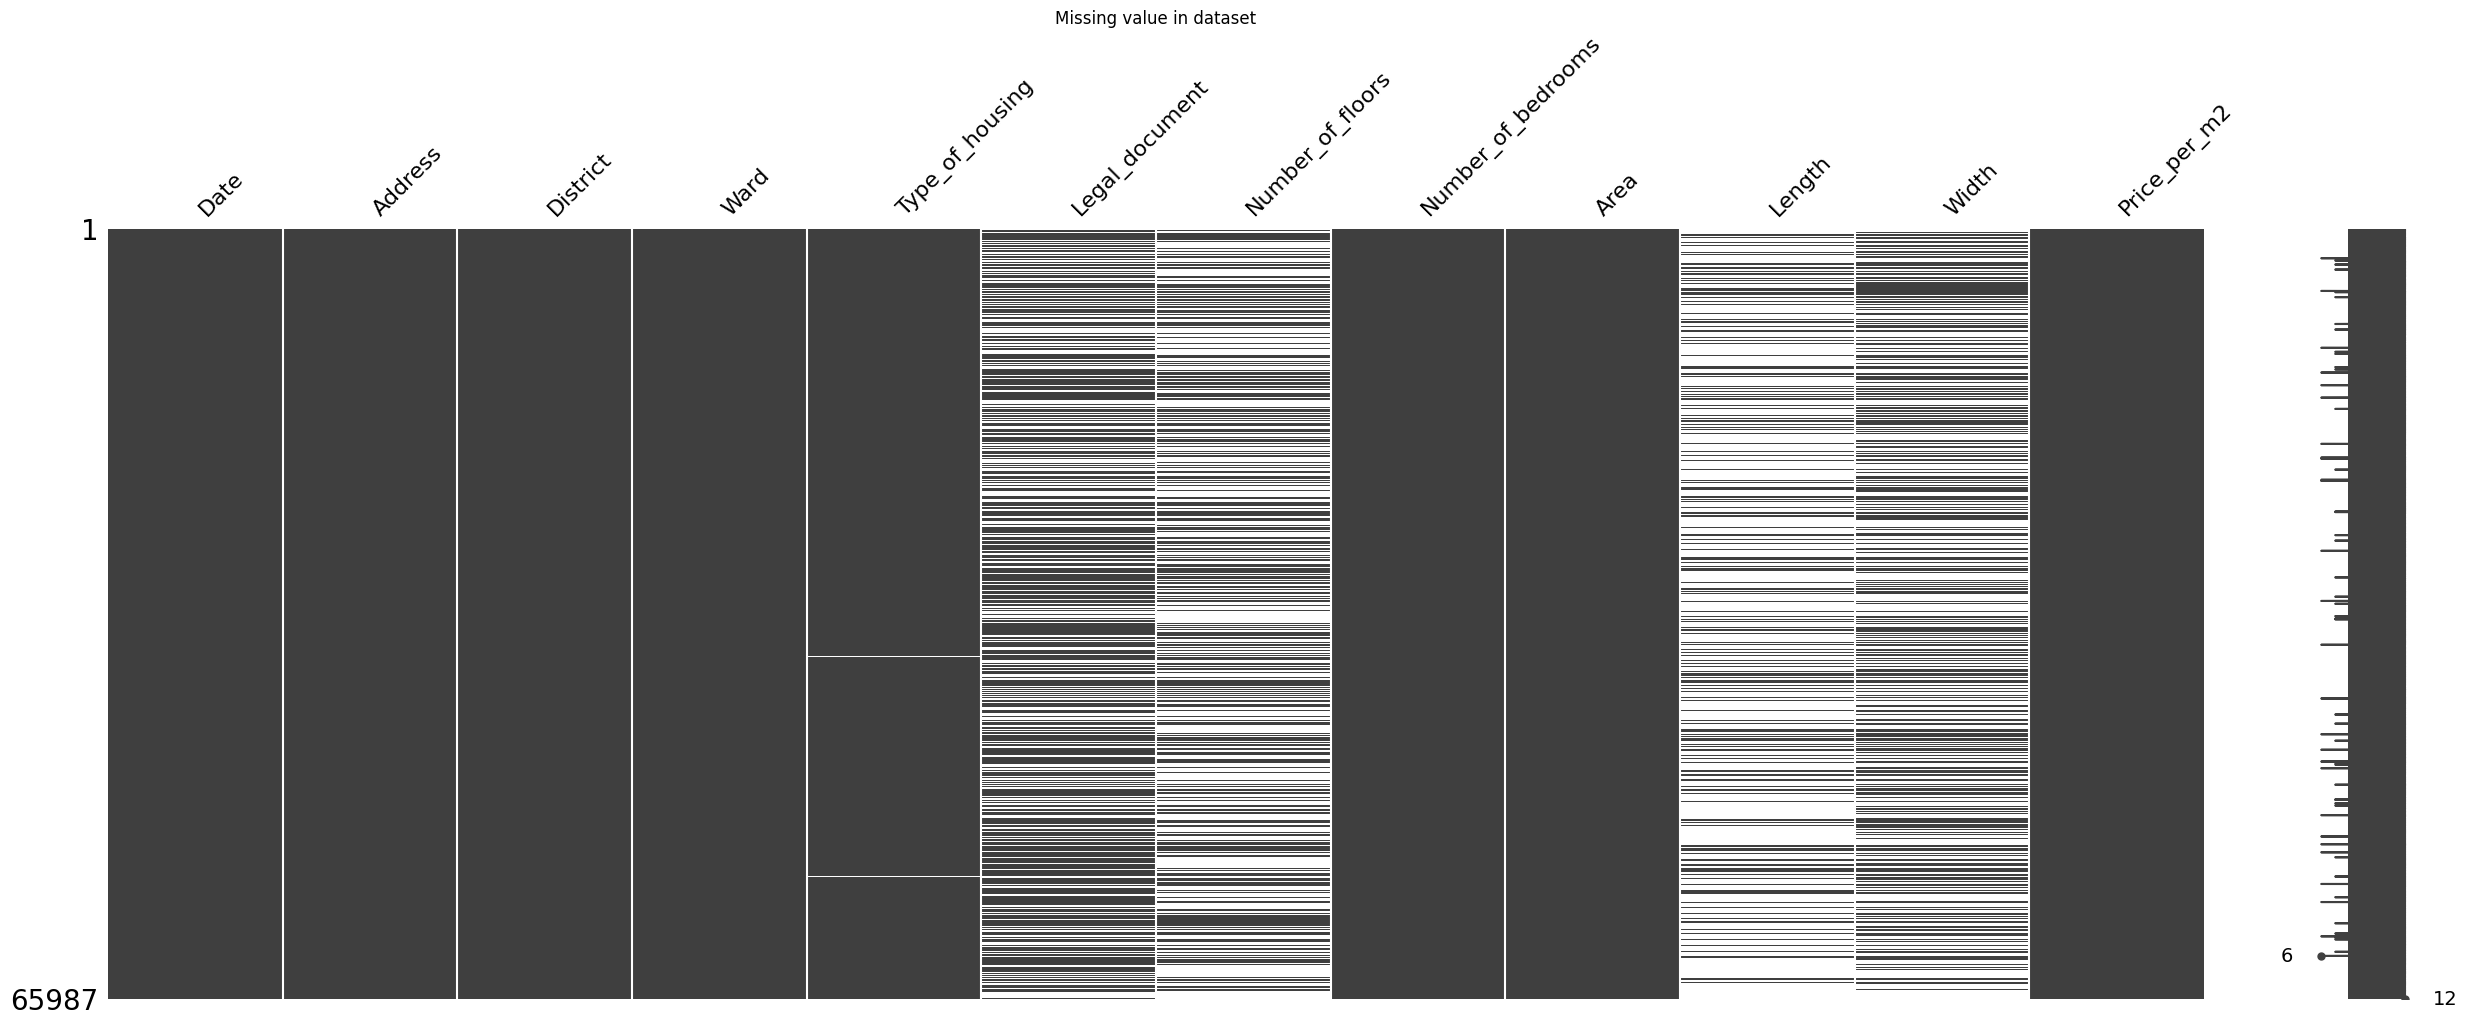

In [17]:
msno.matrix(df_train, figsize = (30,10))
plt.title('Missing value in dataset')
plt.show()

In [18]:
# Missing values ratio in each column in train set

ratio_nan_per_col = df_train.isna().sum() / len(df_train)
ratio_nan_per_col

Date                 0.000000000
Address              0.000591026
District             0.000000000
Ward                 0.000651644
Type_of_housing      0.000394017
Legal_document       0.349947717
Number_of_floors     0.559019201
Number_of_bedrooms   0.000454635
Area                 0.000000000
Length               0.759437465
Width                0.570385076
Price_per_m2         0.000000000
dtype: float64

In [19]:
print('Number of rows before dropping missing values:', len(df_train))

Number of rows before dropping missing values: 65987


In [20]:
# Drop rows with missing values greater than threshold

threshold = 0.01
df_train.dropna(subset=df_train.columns[ratio_nan_per_col < threshold], inplace=True)

In [21]:
print('Number of rows after dropping missing values:', len(df_train))

Number of rows after dropping missing values: 65883


In [22]:
# Missing values ratio in each column in test set

ratio_nan_per_col = df_test.isna().sum() / len(df_test)
ratio_nan_per_col

Date                 0.000000000
Address              0.000484937
District             0.000060617
Ward                 0.000242468
Type_of_housing      0.000303085
Legal_document       0.350972904
Number_of_floors     0.557737771
Number_of_bedrooms   0.000484937
Area                 0.000000000
Length               0.760623144
Width                0.570224889
Price_per_m2         0.000000000
dtype: float64

In [23]:
# Because this is a test set, we can't drop rows with missing values. Instead, we will fill missing values with the most frequent value in each column

idx, value = extract_idx_value(ratio_nan_per_col)
for col, ratio in zip(idx, value):
    if ratio < threshold:
        df_test[col].fillna(df_test[col].mode()[0], inplace=True)


### 'Legal_document' column

In [24]:
df_train['Legal_document'].isna().sum()

23026

In [25]:
# Because the 'Legal_document' column has a lot of missing values, we will try to fill them with 'Unknown' value

df_train['Legal_document'].fillna('Unknown', inplace=True)
df_test['Legal_document'].fillna('Unknown', inplace=True)

### 'Number_of_floors' column

In [26]:
df_train['Number_of_floors'].isna().sum()

36790

In [27]:
# Because the 'Number_of_floors' column has a lot of missing values, we will try to fill them with 'Unknown' value

df_train['Number_of_floors'].fillna('Unknown', inplace=True)
df_test['Number_of_floors'].fillna('Unknown', inplace=True)

### 'Length', 'Width' columns

In [28]:
# We don't need the 'Length', 'Width' columns because we already have the 'Area' column

df_train.drop(['Length', 'Width'], axis=1, inplace=True)
df_test.drop(['Length', 'Width'], axis=1, inplace=True)

### 'Address' column

In [29]:
# We don't need the 'Address' column because we already have the 'District' and 'Ward' columns

df_train.drop(['Address'], axis=1, inplace=True)
df_test.drop(['Address'], axis=1, inplace=True)

**Dataset don't have any missing value**

In [30]:
print('Number of missing values in train set:')
df_train.isna().sum()

Number of missing values in train set:


Date                  0
District              0
Ward                  0
Type_of_housing       0
Legal_document        0
Number_of_floors      0
Number_of_bedrooms    0
Area                  0
Price_per_m2          0
dtype: int64

In [31]:
print('Number of missing values in test set:')
df_test.isna().sum()

Number of missing values in test set:


Date                  0
District              0
Ward                  0
Type_of_housing       0
Legal_document        0
Number_of_floors      0
Number_of_bedrooms    0
Area                  0
Price_per_m2          0
dtype: int64

In [32]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [33]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65883 entries, 0 to 65882
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Date                65883 non-null  object
 1   District            65883 non-null  object
 2   Ward                65883 non-null  object
 3   Type_of_housing     65883 non-null  object
 4   Legal_document      65883 non-null  object
 5   Number_of_floors    65883 non-null  object
 6   Number_of_bedrooms  65883 non-null  object
 7   Area                65883 non-null  object
 8   Price_per_m2        65883 non-null  object
dtypes: object(9)
memory usage: 4.5+ MB


In [34]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16497 entries, 0 to 16496
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Date                16497 non-null  object
 1   District            16497 non-null  object
 2   Ward                16497 non-null  object
 3   Type_of_housing     16497 non-null  object
 4   Legal_document      16497 non-null  object
 5   Number_of_floors    16497 non-null  object
 6   Number_of_bedrooms  16497 non-null  object
 7   Area                16497 non-null  object
 8   Price_per_m2        16497 non-null  object
dtypes: object(9)
memory usage: 1.1+ MB


## Process data types

In [35]:
# Convert 'Date' column to datetime type

df_train['Date'] = pd.to_datetime(df_train['Date'])
df_test['Date'] = pd.to_datetime(df_test['Date'])

In [36]:
df_train['Date'].max()

Timestamp('2020-08-05 00:00:00')

In [37]:
df_train['Date'].min()

Timestamp('2019-08-05 00:00:00')

### 'District' column

In [38]:
df_train['District'].unique()

array(['Quận Hoàng Mai', 'Quận Hà Đông', 'Quận Hai Bà Trưng',
       'Quận Đống Đa', 'Quận Cầu Giấy', 'Quận Ba Đình',
       'Quận Nam Từ Liêm', 'Huyện Thanh Trì', 'Quận Tây Hồ',
       'Quận Thanh Xuân', 'Quận Long Biên', 'Huyện Gia Lâm',
       'Quận Bắc Từ Liêm', 'Huyện Quốc Oai', 'Huyện Hoài Đức',
       'Quận Hoàn Kiếm', 'Huyện Đông Anh', 'Huyện Thanh Oai',
       'Thị xã Sơn Tây', 'Huyện Sóc Sơn', 'Huyện Đan Phượng',
       'Huyện Thường Tín', 'Huyện Chương Mỹ', 'Huyện Phúc Thọ',
       'Huyện Mê Linh', 'Huyện Thạch Thất', 'Huyện Ba Vì',
       'Huyện Phú Xuyên'], dtype=object)

In [39]:
# Replace typos in 'District' column if greater than 98% match

for quan in df_train['District'].unique():
    replace_matches_in_column(df=df_train, column='District', string_to_match=quan, min_ratio=98)
    replace_matches_in_column(df=df_test, column='District', string_to_match=quan, min_ratio=98)

print('Done!')

Done!


***Normial category***

Convert datatype of 'District' column to 'category'

Nếu các giá trị của 1 cột là hữu hạn, ta nên đưa nó về category, nó sẽ giúp tiết kiệm bộ nhớ, cũng như có thể sử dụng các phương thức khác, mà kiểu object không thể, mặc dù cả hai đều chứa string.<br>
Trong trường hợp, cột đó chứa feedback, hoặc description của sản phẩm, thì ta sẽ để nó ở kiểu object.

In [40]:
before = df_train['District'].memory_usage()  # memory usage of column in bytes
print(f'Before convert to category: {before * 1e-3} kb')

Before convert to category: 527.192 kb


In [41]:
df_train['District'] = df_train['District'].astype('category')

# To make sure the test set has the same categories as the training set, we will use the CategoricalDtype function
df_test['District'] = df_test['District'].astype(CategoricalDtype(categories=df_train['District'].cat.categories))

after = df_train['District'].memory_usage()
print(f'After convert to category: {after * 1e-3} kb')

result = (before - after) / before
print(f"After convert to category, the memory usage of the 'District' column is reduced by: {round(result * 100, 2)}%")

After convert to category: 67.307 kb
After convert to category, the memory usage of the 'District' column is reduced by: 87.23%


After convert to category, we can encode, sort or compare value

In [42]:
df_train['District'].cat.categories

Index(['Huyện Ba Vì', 'Huyện Chương Mỹ', 'Huyện Gia Lâm', 'Huyện Hoài Đức',
       'Huyện Mê Linh', 'Huyện Phú Xuyên', 'Huyện Phúc Thọ', 'Huyện Quốc Oai',
       'Huyện Sóc Sơn', 'Huyện Thanh Oai', 'Huyện Thanh Trì',
       'Huyện Thường Tín', 'Huyện Thạch Thất', 'Huyện Đan Phượng',
       'Huyện Đông Anh', 'Quận Ba Đình', 'Quận Bắc Từ Liêm', 'Quận Cầu Giấy',
       'Quận Hai Bà Trưng', 'Quận Hoàn Kiếm', 'Quận Hoàng Mai', 'Quận Hà Đông',
       'Quận Long Biên', 'Quận Nam Từ Liêm', 'Quận Thanh Xuân', 'Quận Tây Hồ',
       'Quận Đống Đa', 'Thị xã Sơn Tây'],
      dtype='object')

In [43]:
df_train['District'].head()

0       Quận Hoàng Mai
1         Quận Hà Đông
2         Quận Hà Đông
3    Quận Hai Bà Trưng
4         Quận Đống Đa
Name: District, dtype: category
Categories (28, object): ['Huyện Ba Vì', 'Huyện Chương Mỹ', 'Huyện Gia Lâm', 'Huyện Hoài Đức', ..., 'Quận Thanh Xuân', 'Quận Tây Hồ', 'Quận Đống Đa', 'Thị xã Sơn Tây']

In [44]:
df_train['District'].cat.codes[:5]

0    20
1    21
2    21
3    18
4    26
dtype: int8

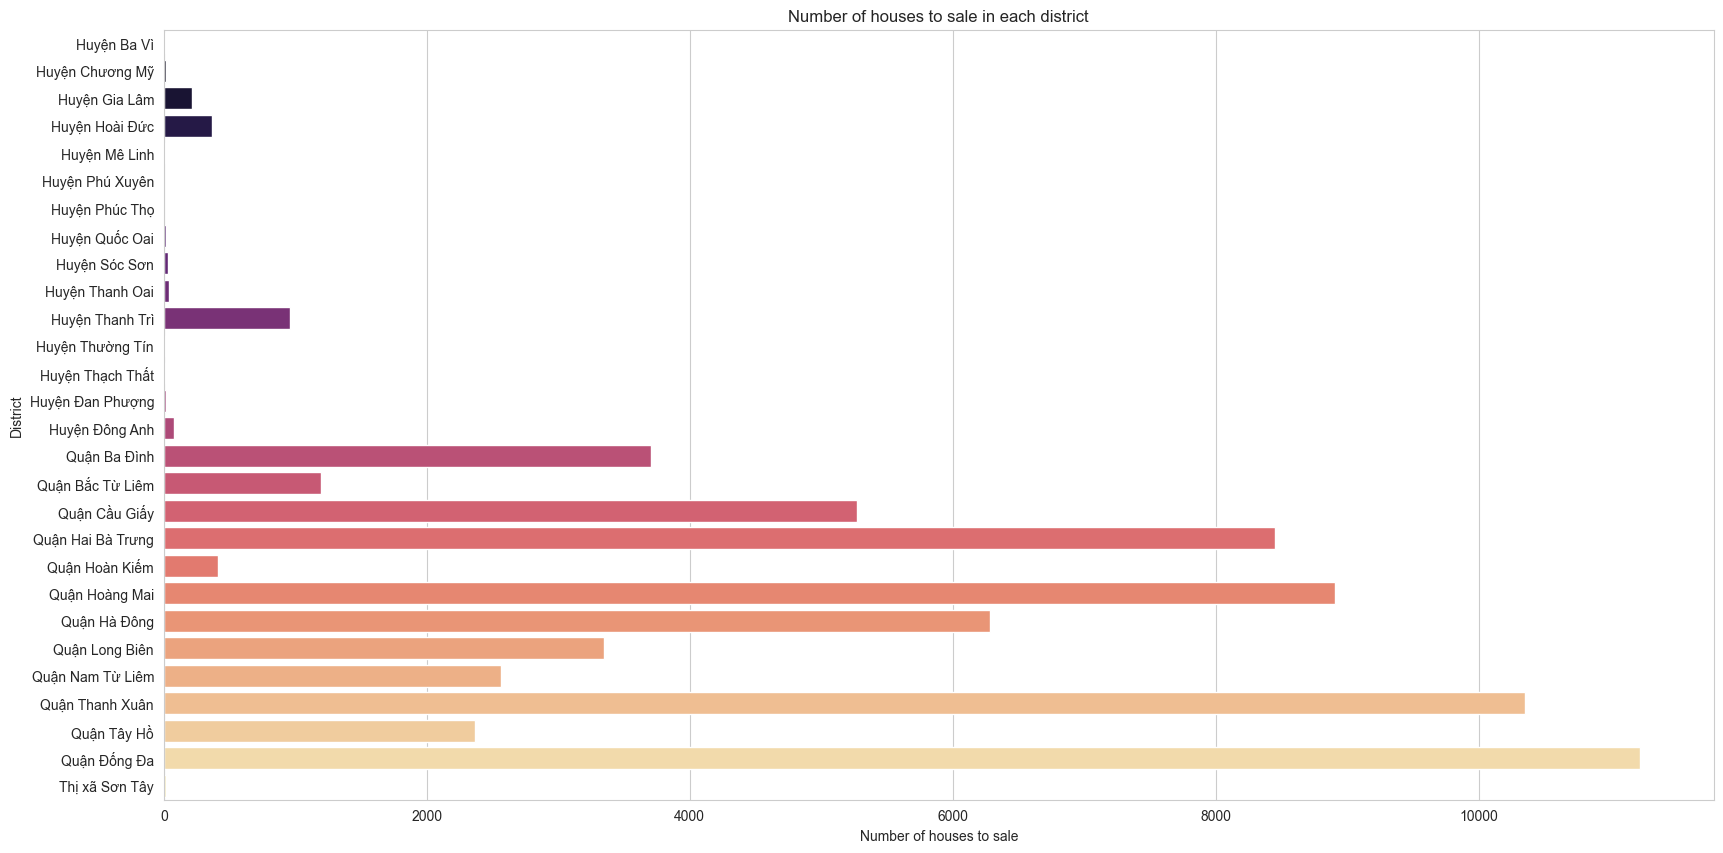

In [45]:
sns.set_style('whitegrid')
plt.figure(figsize=(20, 10))
sns.countplot(data=df_train, y='District', palette='magma')
plt.title('Number of houses to sale in each district')
plt.xlabel('Number of houses to sale')
plt.ylabel('District')
plt.show()

### 'Legal_documents' column

***Ordinal Category***

Convert data type to Ordinal category similar to Norminal category, but we have to specify the order of the categories.<br>
Example: 'thấp' < 'trung bình' < 'cao'

In [46]:
df_train['Legal_document'].unique()

array(['Đã có sổ', 'Unknown', 'Đang chờ sổ', 'Giấy tờ khác'], dtype=object)

We can assume order of the legal documents from the worst to the best is: Unknown < Giấy tờ khác < Đang chờ sổ < Đã có sổ

In [47]:
# Before convert to orinal category

df_train[df_train['Legal_document'] > 'Giấy tờ khác']['Legal_document'].unique()

array(['Đã có sổ', 'Unknown', 'Đang chờ sổ'], dtype=object)

In [48]:
# After convert ordinal category

order_of_legal_document = ['Unknown', 'Giấy tờ khác', 'Đang chờ sổ', 'Đã có sổ']
df_train['Legal_document'] = df_train['Legal_document'].astype(CategoricalDtype(categories=order_of_legal_document, ordered=True))
df_test['Legal_document'] = df_test['Legal_document'].astype(CategoricalDtype(categories=order_of_legal_document, ordered=True))

In [49]:
# Filter rows with 'Legal_document' > 'Giấy tờ khác'

df_train[df_train['Legal_document'] > 'Giấy tờ khác']['Legal_document'].unique()

['Đã có sổ', 'Đang chờ sổ']
Categories (4, object): ['Unknown' < 'Giấy tờ khác' < 'Đang chờ sổ' < 'Đã có sổ']

In [50]:
df_train['Legal_document'].head()

0    Đã có sổ
1    Đã có sổ
2    Đã có sổ
3    Đã có sổ
4    Đã có sổ
Name: Legal_document, dtype: category
Categories (4, object): ['Unknown' < 'Giấy tờ khác' < 'Đang chờ sổ' < 'Đã có sổ']

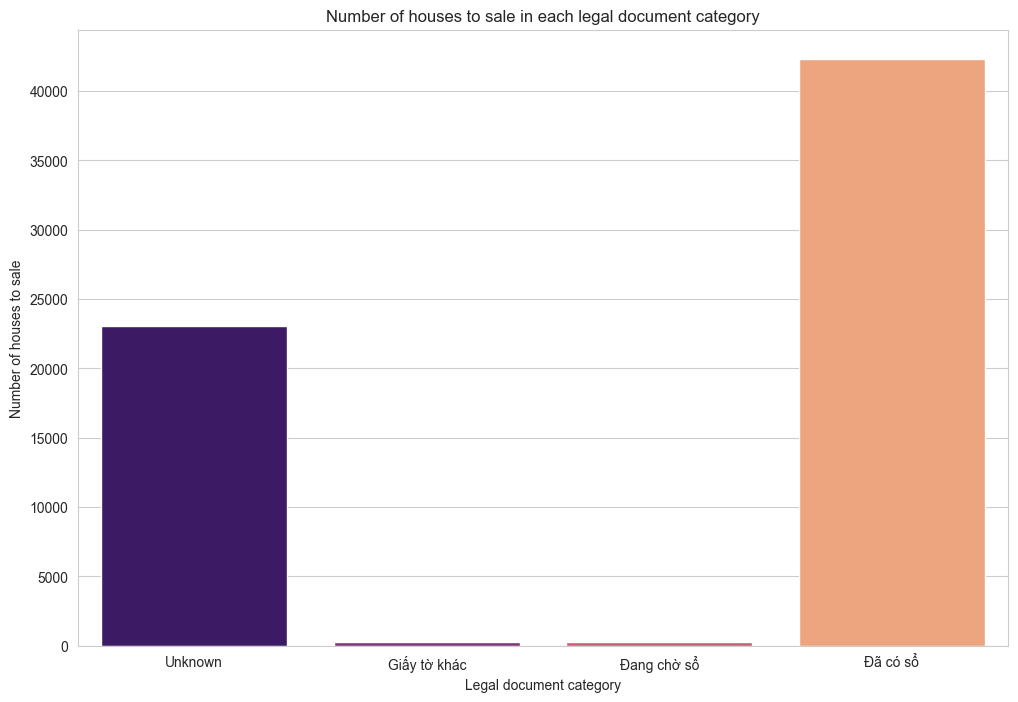

In [51]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df_train, x='Legal_document', palette='magma')
plt.title('Number of houses to sale in each legal document category')
plt.xlabel('Legal document category')
plt.ylabel('Number of houses to sale')
plt.show()

### 'Type_of_housing' column

In [52]:
df_train['Type_of_housing'].unique()

array(['Nhà ngõ, hẻm', 'Nhà mặt phố, mặt tiền', 'Nhà biệt thự',
       'Nhà phố liền kề'], dtype=object)

In [53]:
order_of_type_of_housing = ['Nhà ngõ, hẻm', 'Nhà mặt phố, mặt tiền', 'Nhà phố liền kề', 'Nhà biệt thự']
df_train['Type_of_housing'] = df_train['Type_of_housing'].astype(CategoricalDtype(categories=order_of_type_of_housing, ordered=True))
df_test['Type_of_housing'] = df_test['Type_of_housing'].astype(CategoricalDtype(categories=order_of_type_of_housing, ordered=True))

In [54]:
df_train['Type_of_housing'].head()

0             Nhà ngõ, hẻm
1             Nhà ngõ, hẻm
2             Nhà ngõ, hẻm
3             Nhà ngõ, hẻm
4    Nhà mặt phố, mặt tiền
Name: Type_of_housing, dtype: category
Categories (4, object): ['Nhà ngõ, hẻm' < 'Nhà mặt phố, mặt tiền' < 'Nhà phố liền kề' < 'Nhà biệt thự']

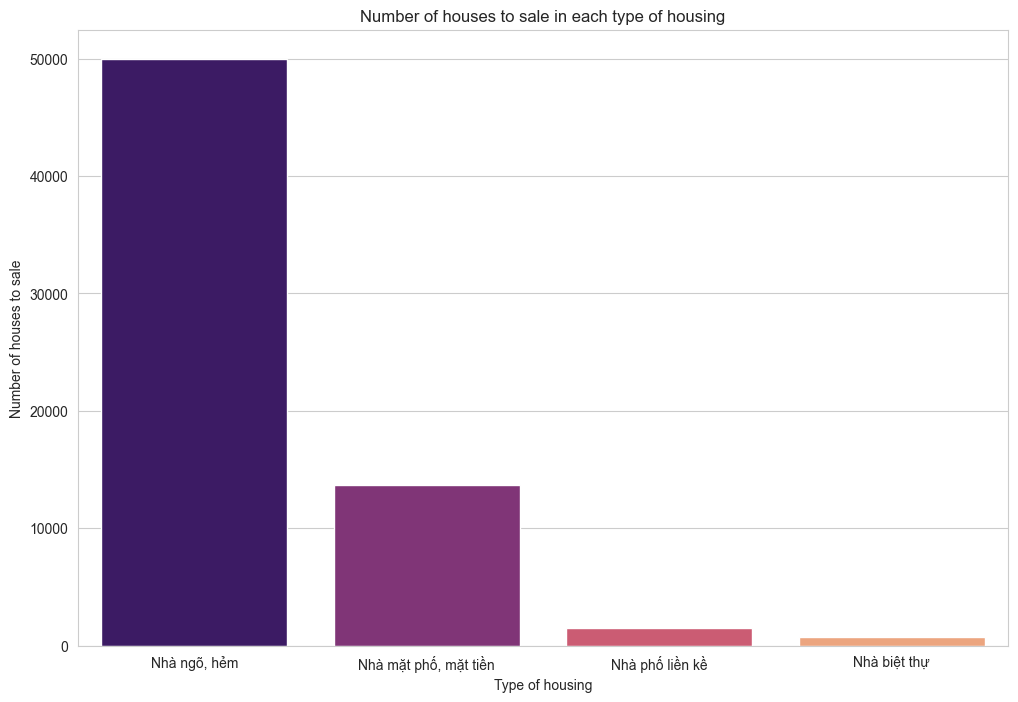

In [55]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df_train, x='Type_of_housing', palette='magma')
plt.title('Number of houses to sale in each type of housing')
plt.xlabel('Type of housing')
plt.ylabel('Number of houses to sale')
plt.show()

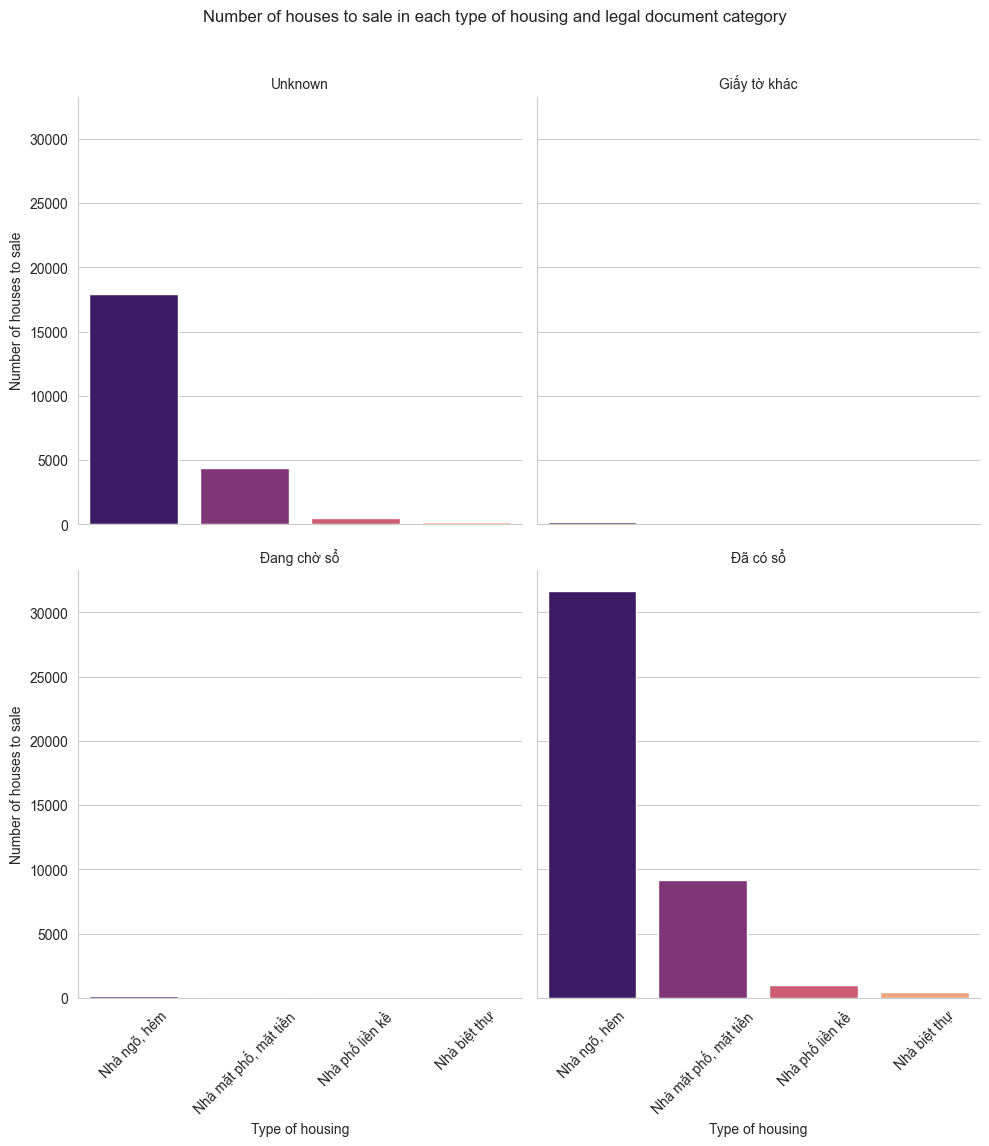

In [56]:
g = sns.catplot(data=df_train, x='Type_of_housing', col='Legal_document', kind='count', col_wrap=2, palette='magma')
g.set_axis_labels('Type of housing', 'Number of houses to sale')
g.fig.suptitle('Number of houses to sale in each type of housing and legal document category', y=1.05)
g.set_titles('{col_name}')
g.tick_params(axis='x', rotation=45)
plt.show()

### 'Ward' column

In [57]:
df_train['Ward'].unique()

array(['Phường Tương Mai', 'Phường Yên Nghĩa', 'Phường Vạn Phúc',
       'Phường Thanh Nhàn', 'Phường Thịnh Quang', 'Phường Trung Liệt',
       'Phường Đồng Tâm', 'Phường Quan Hoa', 'Phường Đống Mác',
       'Phường Liễu Giai', 'Phường Phú Đô', 'Xã Tân Triều',
       'Phường Phú Lương', 'Phường Hoàng Văn Thụ', 'Phường Thụy Khuê',
       'Phường Trương Định', 'Phường Khương Đình', 'Phường Đại Kim',
       'Phường Phương Canh', 'Phường Trung Văn', 'Phường Ô Chợ Dừa',
       'Phường Đức Giang', 'Phường Cầu Dền', 'Phường Thạch Bàn',
       'Phường Bưởi', 'Phường Thanh Lương', 'Phường Ngọc Lâm',
       'Xã Đông Dư', 'Phường Láng Hạ', 'Phường Văn Quán',
       'Phường Nhân Chính', 'Phường La Khê', 'Phường Dịch Vọng',
       'Phường Khương Mai', 'Phường Điện Biên', 'Phường Vĩnh Phúc',
       'Phường Yên Hoà', 'Phường Cổ Nhuế 1', 'Phường Kiến Hưng',
       'Phường Bạch Đằng', 'Phường Định Công', 'Phường Nam Đồng',
       'Phường Ngọc Khánh', 'Phường Yên Sở', 'Phường Nghĩa Đô',
       'Phường X

In [58]:
df_train['Ward'] = df_train['Ward'].astype('category')
df_test['Ward'] = df_test['Ward'].astype(CategoricalDtype(categories=df_train['Ward'].cat.categories))

### 'Number_of_floors' column

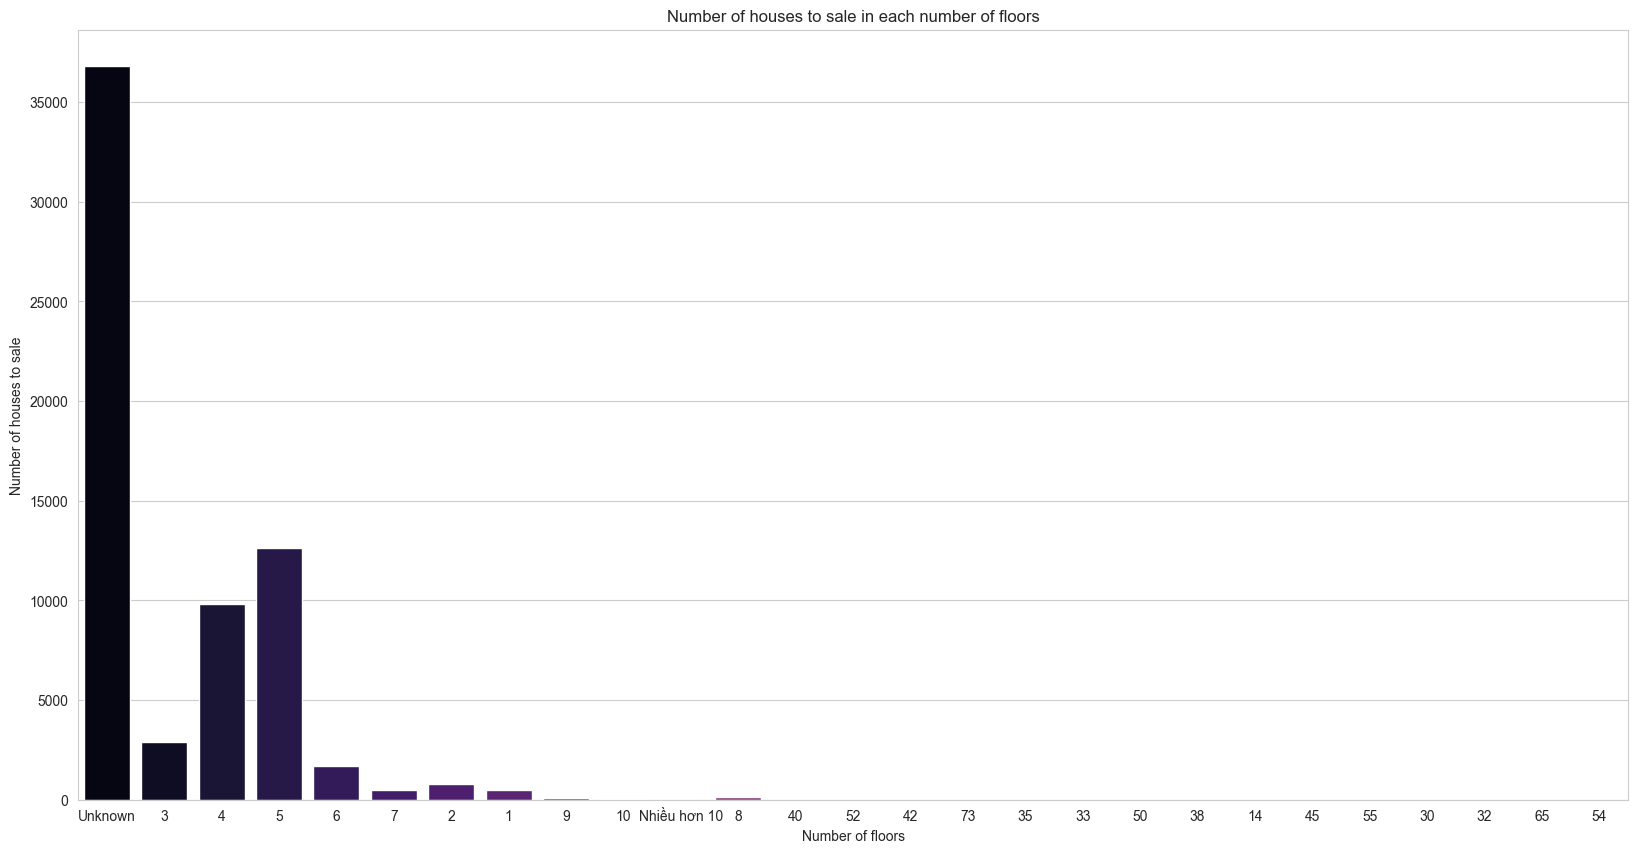

In [59]:
plt.figure(figsize=(20, 10))
sns.countplot(data=df_train, x='Number_of_floors', palette='magma')
plt.title('Number of houses to sale in each number of floors')
plt.xlabel('Number of floors')
plt.ylabel('Number of houses to sale')
plt.show()

Number or category greater than 10 is too few, we will group them into '10' category

In [60]:
def process_so_tang(x):
    try:
        if x == 'Nhiều hơn 10' or int(x) > 10:
            return '10'
        return x
    except:
        return x

In [61]:
df_train['Number_of_floors'] = df_train['Number_of_floors'].apply(process_so_tang)
df_test['Number_of_floors'] = df_test['Number_of_floors'].apply(process_so_tang)

In [62]:
df_train['Number_of_floors'].value_counts()

Number_of_floors
Unknown    36790
5          12637
4           9831
3           2889
6           1681
2            811
1            506
7            465
8            147
9             70
10            56
Name: count, dtype: int64

In [63]:
# Convert 'Number_of_floors' column to ordinal category

order_of_number_of_floors = ['Unknown', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10']
df_train['Number_of_floors'] = df_train['Number_of_floors'].astype(CategoricalDtype(categories=order_of_number_of_floors, ordered=True))
df_test['Number_of_floors'] = df_test['Number_of_floors'].astype(CategoricalDtype(categories=order_of_number_of_floors, ordered=True))

In [64]:
df_train['Number_of_floors'].head()

0    Unknown
1    Unknown
2          3
3    Unknown
4    Unknown
Name: Number_of_floors, dtype: category
Categories (11, object): ['Unknown' < '1' < '2' < '3' ... '7' < '8' < '9' < '10']

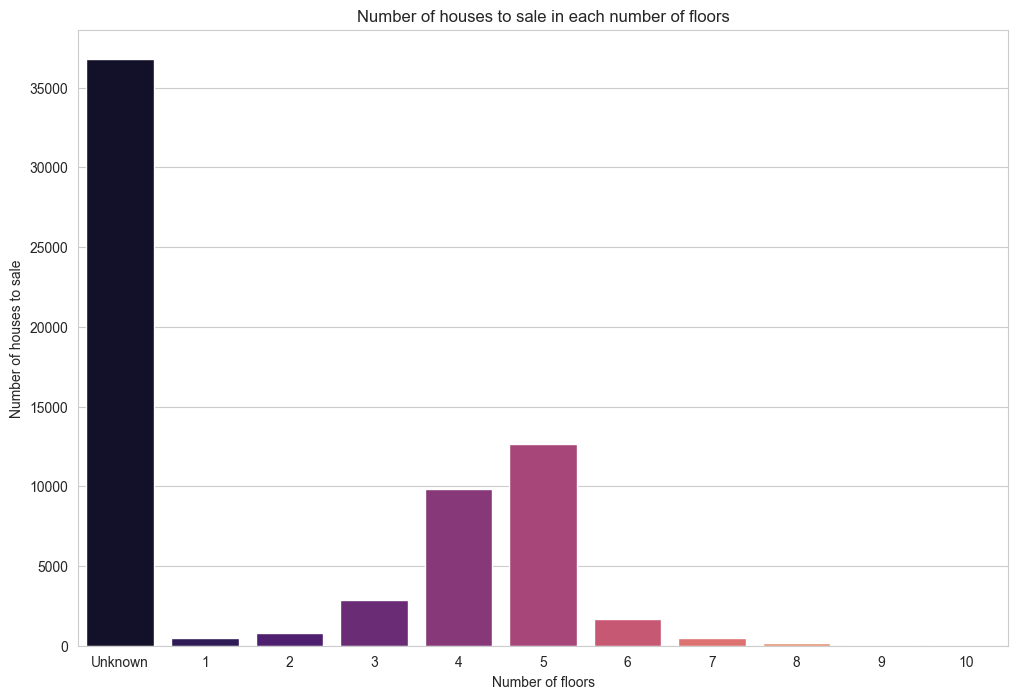

In [65]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df_train, x='Number_of_floors', palette='magma')
plt.title('Number of houses to sale in each number of floors')
plt.xlabel('Number of floors')
plt.ylabel('Number of houses to sale')
plt.show()

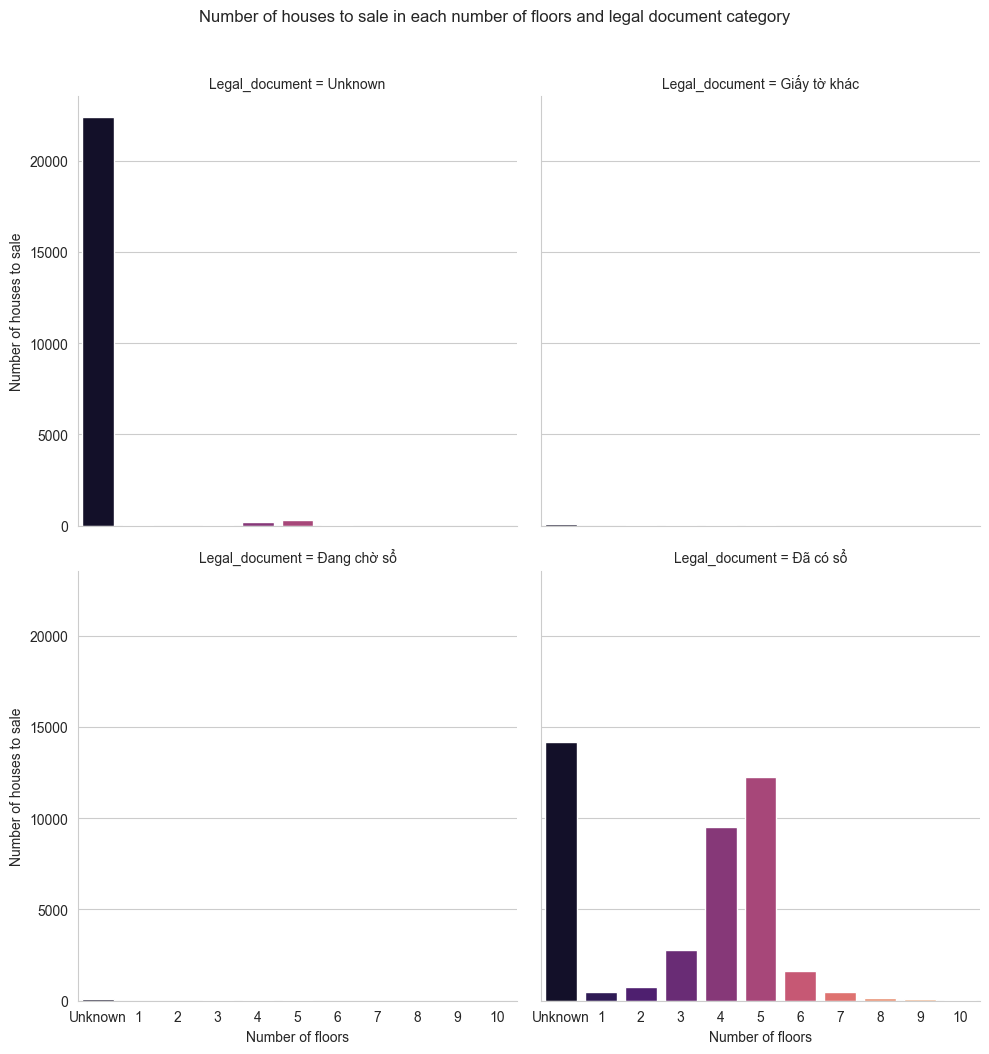

In [66]:
g = sns.catplot(data=df_train, x='Number_of_floors', col='Legal_document', kind='count', col_wrap=2, palette='magma')
g.fig.suptitle('Number of houses to sale in each number of floors and legal document category', y=1.05)
g.set_axis_labels('Number of floors', 'Number of houses to sale')
plt.show()

### 'Number_of_bedrooms' column

In [67]:
df_train['Number_of_bedrooms'].unique()

array(['2 phòng', '4 phòng', '6 phòng', '3 phòng', '8 phòng', '5 phòng',
       '1 phòng', '7 phòng', 'nhiều hơn 10 phòng', '10 phòng', '9 phòng'],
      dtype=object)

In [68]:
# Replace 'nhiều hơn 10 phòng' with '10 phòng'

df_train['Number_of_bedrooms'].replace('nhiều hơn 10 phòng', '10 phòng', inplace=True)
df_test['Number_of_bedrooms'].replace('nhiều hơn 10 phòng', '10 phòng', inplace=True)

In [69]:
# Convert 'Number_of_bedrooms' column to numeric type

df_train['Number_of_bedrooms'] = df_train['Number_of_bedrooms'].str.replace('phòng', '')
df_train['Number_of_bedrooms'] = df_train['Number_of_bedrooms'].astype('int')

df_test['Number_of_bedrooms'] = df_test['Number_of_bedrooms'].str.replace('phòng', '')
df_test['Number_of_bedrooms'] = df_test['Number_of_bedrooms'].astype('int')

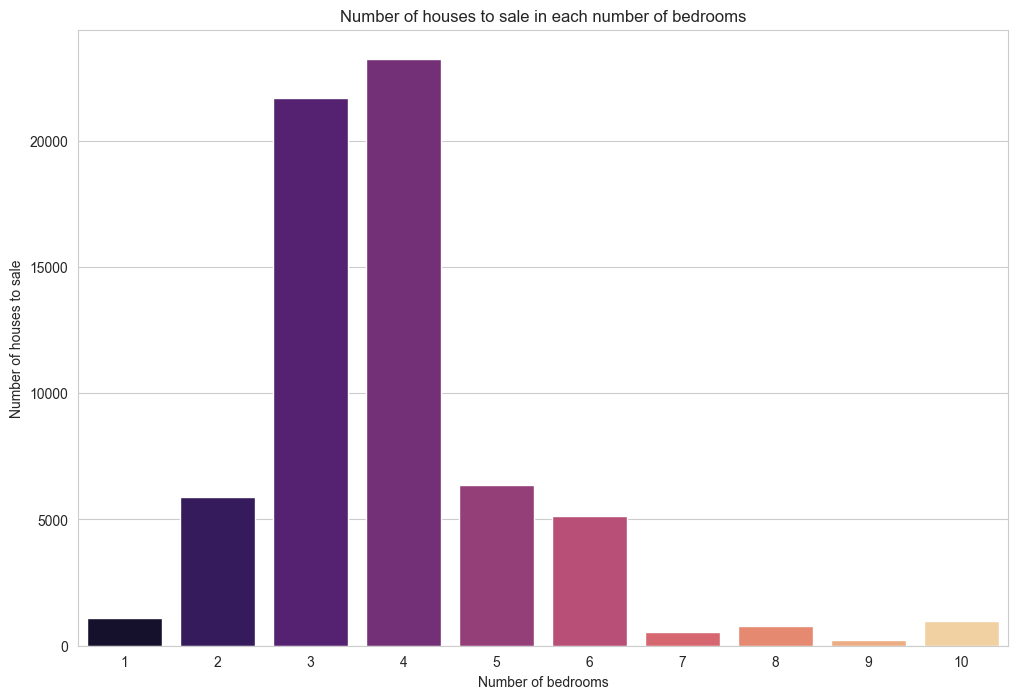

In [70]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df_train, x='Number_of_bedrooms', palette='magma')
plt.title('Number of houses to sale in each number of bedrooms')
plt.xlabel('Number of bedrooms')
plt.ylabel('Number of houses to sale')
plt.show()

### 'Area' column

In [71]:
# Remove 'm²' and replace ',' with '.' to convert data type to float

df_train['Area'] = df_train['Area'].apply(lambda x: x.replace('m²', '').replace(',', '.')).astype(float)
df_test['Area'] = df_test['Area'].apply(lambda x: x.replace('m²', '').replace(',', '.')).astype(float)

### 'Price_per_m2' column

In [72]:
df_train['Price_per_m2'].value_counts()

Price_per_m2
100 triệu/m²       2014
80 triệu/m²         909
75 triệu/m²         763
90 triệu/m²         674
83,33 triệu/m²      647
                   ... 
163,83 triệu/m²       1
21,62 triệu/m²        1
15,28 triệu/m²        1
68.292 đ/m²           1
36,89 triệu/m²        1
Name: count, Length: 7553, dtype: int64

Price_per_m2 column has string values with price + unit, we will move the unit to the Unit column

In [73]:
print('Units:')
units = df_train['Price_per_m2'].apply(lambda x: x.split(' ')[1])
units.value_counts()

Units:


Price_per_m2
triệu/m²    65209
đ/m²          587
tỷ/m²          87
Name: count, dtype: int64

In [74]:
df_train[units == 'đ/m²']

Date          District                     Ward  \
67    2020-07-13    Quận Hoàng Mai        Phường Thịnh Liệt   
205   2020-07-13  Quận Nam Từ Liêm       Phường Xuân Phương   
288   2020-07-20      Quận Hà Đông          Phường Văn Quán   
299   2020-07-22   Quận Thanh Xuân  Phường Thanh Xuân Trung   
353   2020-07-25     Quận Cầu Giấy          Phường Mai Dịch   
...          ...               ...                      ...   
65522 2020-06-27   Quận Thanh Xuân        Phường Khương Mai   
65606 2020-07-03  Quận Nam Từ Liêm            Phường Phú Đô   
65615 2020-06-08      Quận Hà Đông           Phường Phúc La   
65734 2020-06-18     Quận Cầu Giấy          Phường Mai Dịch   
65790 2020-07-11  Quận Nam Từ Liêm         Phường Mỹ Đình 2   

             Type_of_housing Legal_document Number_of_floors  \
67              Nhà ngõ, hẻm        Unknown          Unknown   
205             Nhà biệt thự        Unknown          Unknown   
288             Nhà ngõ, hẻm       Đã có sổ                5   
299    Nhà mặt phố, mặt tiền        Unknown          Unknown   
353             Nhà ngõ, hẻm        Unknown          Unknown   
...                      ...            ...              ...   
65522           Nhà ngõ, hẻm       Đã có sổ                5   
65606           Nhà ngõ, hẻm        Unknown          Unknown   
65615        Nhà phố liền kề       Đã có sổ                4   
65734  Nhà mặt phố, mặt tiền       Đã có sổ                4   
65790  Nhà mặt phố, mặt tiền       Đã có sổ          Unknown   

       Number_of_bedrooms          Area  Price_per_m2  
67                      3  33.000000000   80.303 đ/m²  
205                     5 200.000000000   29.500 đ/m²  
288                     5  37.000000000  112.162 đ/m²  
299                     4  40.000000000  100.000 đ/m²  
353                     4  61.000000000   73.770 đ/m²  
...                   ...           ...           ...  
65522                   4  31.000000000   90.000 đ/m²  
65606                   3  31.000000000   70.967 đ/m²  
65615                   4  50.000000000   97.000 đ/m²  
65734                   5  44.000000000  173.863 đ/m²  
65790                   6  75.000000000   73.333 đ/m²  

[587 rows x 9 columns]

**'đ/m²' may be a typo of 'triệu/m²'**

In [75]:
df_train[units == 'tỷ/m²']

Date          District                Ward        Type_of_housing  \
1832  2020-06-08    Quận Hoàn Kiếm   Phường Lý Thái Tổ  Nhà mặt phố, mặt tiền   
2050  2020-08-03    Quận Hoàn Kiếm      Phường Hàng Bồ  Nhà mặt phố, mặt tiền   
4118  2020-07-20   Quận Thanh Xuân  Phường Thượng Đình           Nhà ngõ, hẻm   
4688  2020-07-17      Quận Đống Đa    Phường Ô Chợ Dừa           Nhà ngõ, hẻm   
5082  2020-06-30    Quận Hoàng Mai     Phường Mai Động  Nhà mặt phố, mặt tiền   
...          ...               ...                 ...                    ...   
59380 2020-07-19  Quận Nam Từ Liêm       Phường Mễ Trì  Nhà mặt phố, mặt tiền   
61093 2020-08-04      Quận Hà Đông       Phường La Khê        Nhà phố liền kề   
61490 2020-07-31    Quận Long Biên    Phường Long Biên           Nhà ngõ, hẻm   
62002 2020-07-31  Quận Nam Từ Liêm       Phường Phú Đô           Nhà ngõ, hẻm   
64910 2020-06-11      Quận Đống Đa     Phường Hàng Bột           Nhà ngõ, hẻm   

      Legal_document Number_of_floors  Number_of_bedrooms          Area  \
1832         Unknown          Unknown                   4 100.000000000   
2050        Đã có sổ                8                  10 126.000000000   
4118        Đã có sổ          Unknown                   3  25.000000000   
4688        Đã có sổ          Unknown                   2   2.000000000   
5082        Đã có sổ                6                  10  49.000000000   
...              ...              ...                 ...           ...   
59380       Đã có sổ                4                   3 100.000000000   
61093        Unknown          Unknown                   6   5.000000000   
61490       Đã có sổ          Unknown                   4   2.000000000   
62002       Đã có sổ                5                   3  30.000000000   
64910       Đã có sổ                4                   4  65.000000000   

            Price_per_m2  
1832           1,5 tỷ/m²  
2050   1,111111111 tỷ/m²  
4118          1,14 tỷ/m²  
4688          1,25 tỷ/m²  
5082   1,122448979 tỷ/m²  
...                  ...  
59380          8,9 tỷ/m²  
61093         1,96 tỷ/m²  
61490         2,65 tỷ/m²  
62002  1,133333333 tỷ/m²  
64910  7,692307692 tỷ/m²  

[87 rows x 9 columns]

In [76]:
df_train['Unit'] = df_train['Price_per_m2'].apply(lambda x: x.split(' ')[1])
df_train['Price_per_m2'] = df_train['Price_per_m2'].apply(lambda x: x.split(' ')[0])

df_test['Unit'] = df_test['Price_per_m2'].apply(lambda x: x.split(' ')[1])
df_test['Price_per_m2'] = df_test['Price_per_m2'].apply(lambda x: x.split(' ')[0])

In [77]:
# Check if there is any value that cannot be converted to float

idx, values = extract_idx_value(df_train['Price_per_m2'].apply(lambda x: x.replace(',', '.')))

for _idx, value in zip(idx, values):
    try:
        float(value)
    except:
        print(_idx, value)

26102 2.222.22220022
46051 728.000.00728


In [78]:
idx, values = extract_idx_value(df_test['Price_per_m2'].apply(lambda x: x.replace(',', '.')))

for _idx, value in zip(idx, values):
    try:
        float(value)
    except:
        print(_idx, value)

In [79]:
# Remove row with index 26102 and 46051 because they cannot be converted to float

df_train.drop([26102, 46051], inplace=True)
df_train['Price_per_m2'] = df_train['Price_per_m2'].apply(lambda x: x.replace(',', '.')).astype(float)
df_test['Price_per_m2'] = df_test['Price_per_m2'].apply(lambda x: x.replace(',', '.')).astype(float)

In [80]:
df_train.reset_index(drop=True, inplace=True)

In [81]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65881 entries, 0 to 65880
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Date                65881 non-null  datetime64[ns]
 1   District            65881 non-null  category      
 2   Ward                65881 non-null  category      
 3   Type_of_housing     65881 non-null  category      
 4   Legal_document      65881 non-null  category      
 5   Number_of_floors    65881 non-null  category      
 6   Number_of_bedrooms  65881 non-null  int32         
 7   Area                65881 non-null  float64       
 8   Price_per_m2        65881 non-null  float64       
 9   Unit                65881 non-null  object        
dtypes: category(5), datetime64[ns](1), float64(2), int32(1), object(1)
memory usage: 2.7+ MB


**Dataset after process data types**

In [82]:
df_train.describe()

Date  Number_of_bedrooms             Area  \
count                          65881     65881.000000000  65881.000000000   
mean   2020-07-07 17:00:00.382507776         3.874667962     52.165548793   
min              2019-08-05 00:00:00         1.000000000      1.000000000   
25%              2020-06-23 00:00:00         3.000000000     34.000000000   
50%              2020-07-09 00:00:00         4.000000000     40.000000000   
75%              2020-07-24 00:00:00         4.000000000     50.000000000   
max              2020-08-05 00:00:00        10.000000000 111411.000000000   
std                              NaN         1.454825385    525.347406958   

         Price_per_m2  
count 65881.000000000  
mean    102.958278322  
min       1.000000000  
25%      73.250000000  
50%      90.000000000  
75%     110.710000000  
max     998.000000000  
std      65.998854713

# Feature Engineering

In [83]:
# Create a new column 'Price' = 'Price_per_m2' * 'Area' (bilion VND), if 'Unit' != 'tỷ/m²' then 'Price' /= 1000

for row, col in df_train.iterrows():
    df_train.loc[row, 'Price'] = col['Price_per_m2'] * col['Area']
    if col['Unit'] != 'tỷ/m²':
        df_train.loc[row, 'Price'] /= 1000

In [84]:
for row, col in df_test.iterrows():
    df_test.loc[row, 'Price'] = col['Price_per_m2'] * col['Area']
    if col['Unit'] != 'tỷ/m²':
        df_test.loc[row, 'Price'] /= 1000

In [85]:
# Create a new column 'Inner_city' if 'District' have 'Quận'

df_train['Inner_city'] = df_train['District'].apply(lambda x: 1 if 'Quận' in x else 0)
df_test['Inner_city'] = df_test['District'].apply(lambda x: 1 if 'Quận' in x else 0)

In [86]:
# Create a new column 'Year' and 'Month' from 'Date' column

df_train['Year'] = df_train['Date'].dt.year
df_train['Month'] = df_train['Date'].dt.month

df_test['Year'] = df_test['Date'].dt.year
df_test['Month'] = df_test['Date'].dt.month

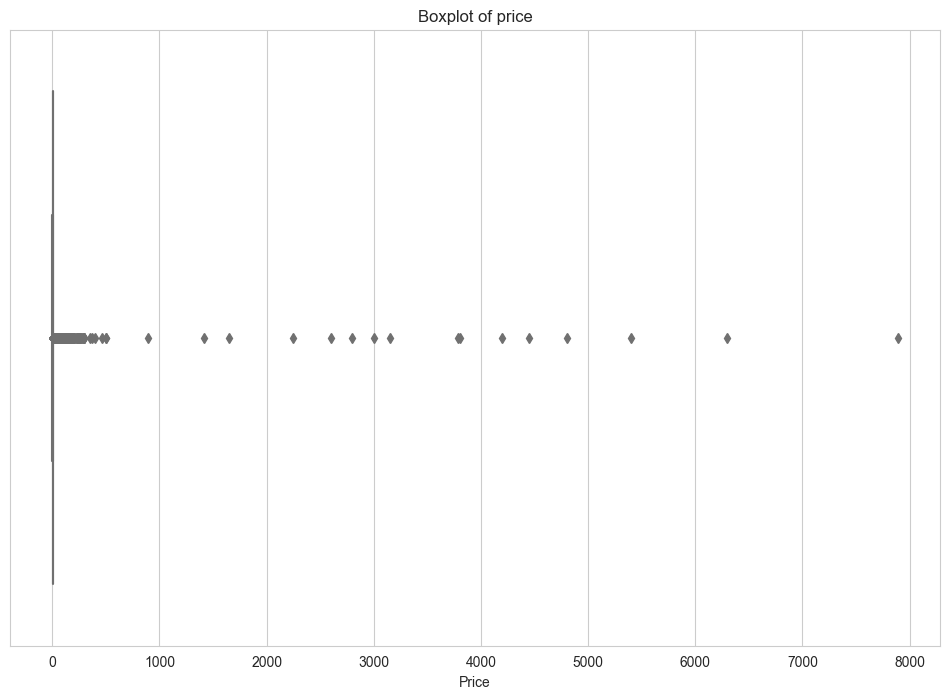

In [87]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train, x='Price', color='#F38181')
plt.title('Boxplot of price')
plt.xlabel('Price')
plt.show()

**Train set have a lot of extreme values, we will remove them to easy visualize and make the predict model more robust**

In [88]:
# Remove outliers in 'Price' column

iqr = df_train['Price'].quantile(0.75) - df_train['Price'].quantile(0.25)
upper_bound = df_train['Price'].quantile(0.75) + 1.5 * iqr
lower_bound = df_train['Price'].quantile(0.25) - 1.5 * iqr

df_train_no_outlier = df_train[(df_train['Price'] < upper_bound) & (df_train['Price'] > lower_bound)]

In [89]:
print(f'Số lượng outlier: {len(df_train) - len(df_train_no_outlier)}')

Số lượng outlier: 6280


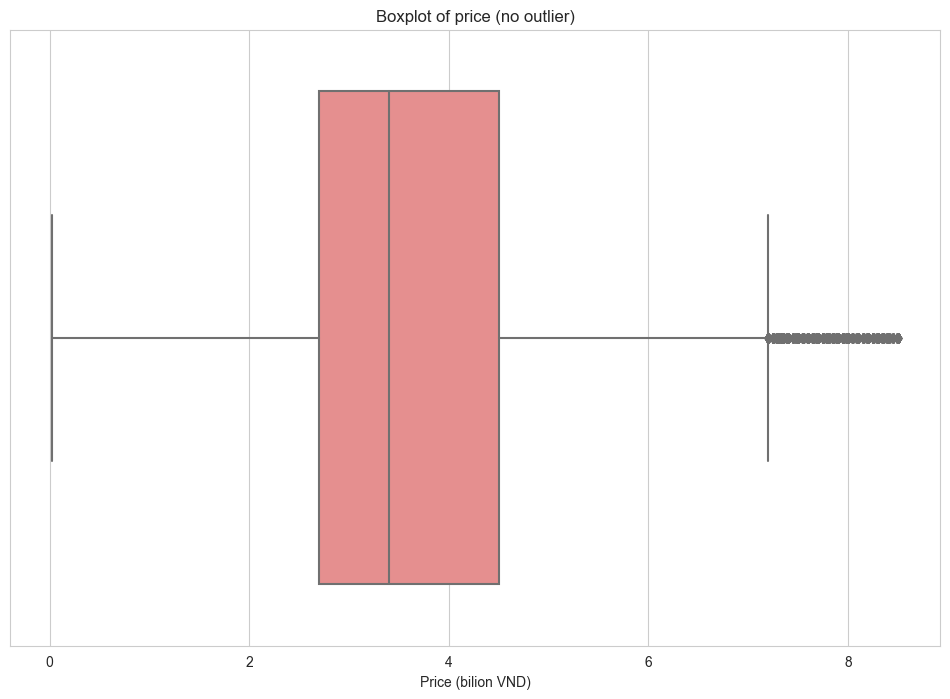

In [90]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train_no_outlier, x='Price', color='#F38181')
plt.title('Boxplot of price (no outlier)')
plt.xlabel('Price (bilion VND)')
plt.show()

In [91]:
df_train_no_outlier.describe()

Date  Number_of_bedrooms            Area  \
count                          59601     59601.000000000 59601.000000000   
mean   2020-07-07 20:59:54.382644480         3.736799718    42.960118454   
min              2019-08-05 00:00:00         1.000000000     1.000000000   
25%              2020-06-23 00:00:00         3.000000000    33.000000000   
50%              2020-07-09 00:00:00         4.000000000    40.000000000   
75%              2020-07-24 00:00:00         4.000000000    48.000000000   
max              2020-08-05 00:00:00        10.000000000  4207.000000000   
std                              NaN         1.278331135    37.384676264   

         Price_per_m2           Price      Inner_city            Year  \
count 59601.000000000 59601.000000000 59601.000000000 59601.000000000   
mean     90.270592893     3.709747373     0.972215231  2019.999781883   
min       1.000000000     0.026000000     0.000000000  2019.000000000   
25%      71.670000000     2.699900000     1.000000000  2020.000000000   
50%      87.100000000     3.399990000     1.000000000  2020.000000000   
75%     103.330000000     4.500000000     1.000000000  2020.000000000   
max     998.000000000     8.499900000     1.000000000  2020.000000000   
std      34.460070071     1.517406929     0.164357016     0.014767303   

                Month  
count 59601.000000000  
mean      6.724987836  
min       2.000000000  
25%       6.000000000  
50%       7.000000000  
75%       7.000000000  
max      12.000000000  
std       0.638387172

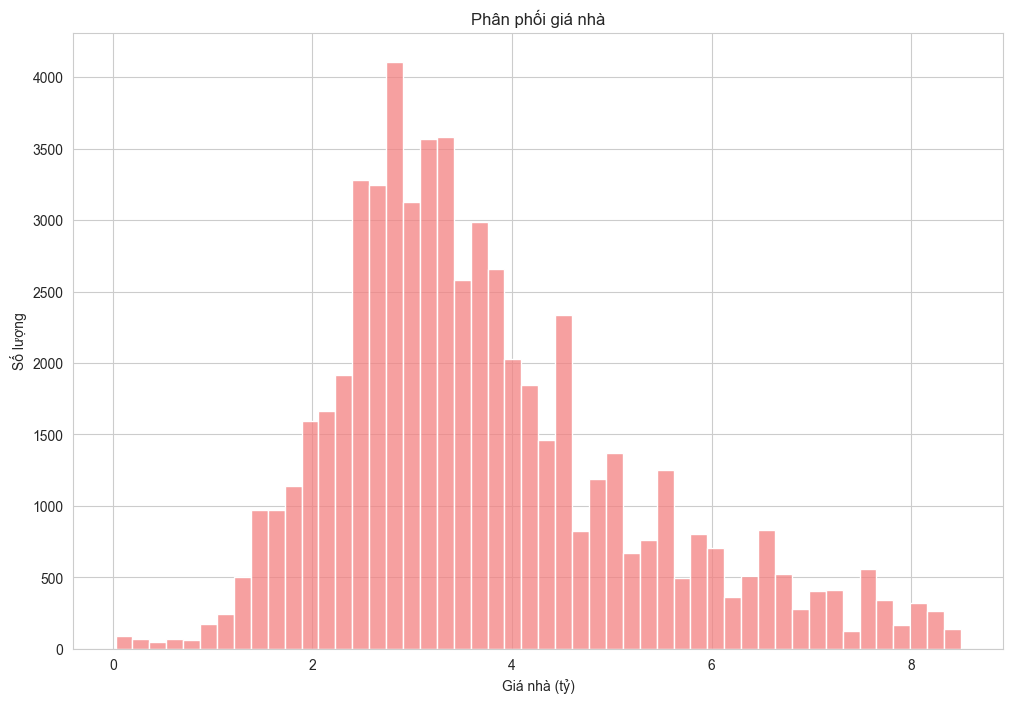

In [103]:
plt.figure(figsize=(12, 8))
sns.histplot(data=df_train_no_outlier, x='Price', bins=50, color='#F38181')
plt.title('Phân phối giá nhà')
plt.xlabel('Giá nhà (tỷ)')
plt.ylabel('Số lượng')
plt.show()

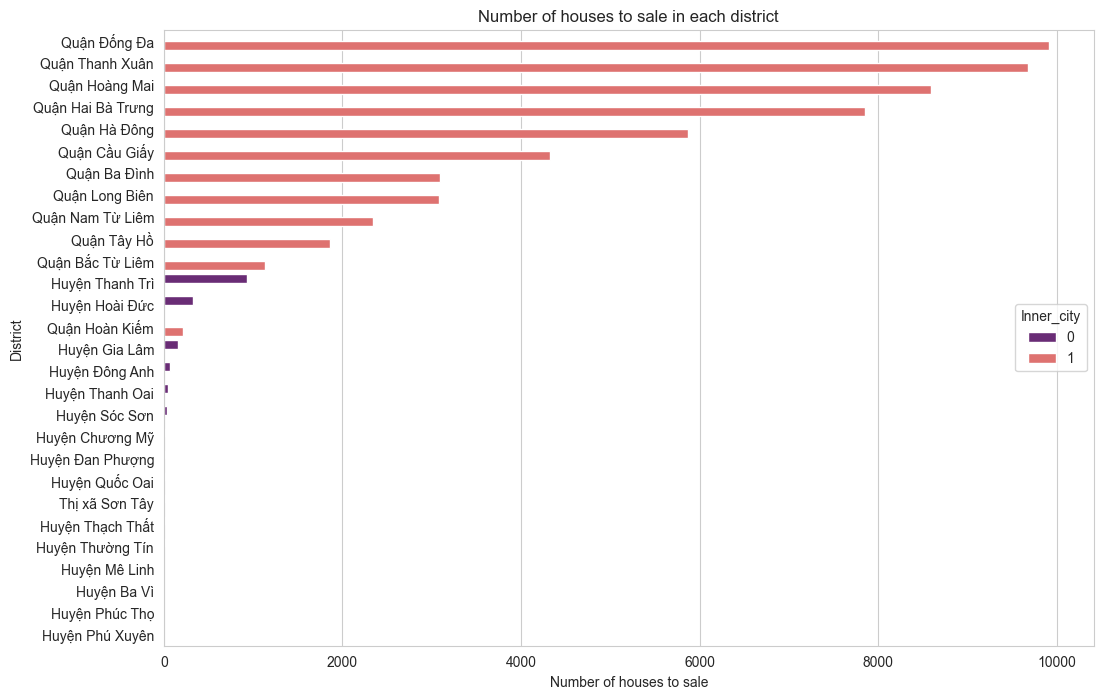

In [93]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df_train_no_outlier, y='District', hue='Inner_city', order=df_train_no_outlier['District'].value_counts().index, palette='magma')
plt.title('Number of houses to sale in each district')
plt.xlabel('Number of houses to sale')
plt.ylabel('District')
plt.show()

In [94]:
df_train_no_outlier.groupby('District')['Price'].mean().sort_values(ascending=False)

District
Huyện Thạch Thất    5.092731111
Quận Cầu Giấy       4.560376670
Huyện Ba Vì         4.550900000
Quận Tây Hồ         4.298711457
Huyện Quốc Oai      4.157169286
Quận Ba Đình        4.005533481
Quận Đống Đa        3.914877781
Quận Thanh Xuân     3.891731290
Quận Hoàn Kiếm      3.854751580
Quận Nam Từ Liêm    3.760277353
Quận Long Biên      3.632982005
Quận Hai Bà Trưng   3.604108911
Huyện Đan Phượng    3.568718000
Quận Bắc Từ Liêm    3.535226007
Huyện Gia Lâm       3.339598590
Quận Hoàng Mai      3.261049142
Quận Hà Đông        3.249754416
Huyện Mê Linh       3.238737143
Huyện Thanh Trì     2.686734193
Huyện Chương Mỹ     2.601325625
Huyện Đông Anh      2.499684232
Huyện Sóc Sơn       2.406941212
Thị xã Sơn Tây      2.387376923
Huyện Phúc Thọ      2.312555000
Huyện Thường Tín    2.163920000
Huyện Hoài Đức      2.026118674
Huyện Thanh Oai     1.592710000
Huyện Phú Xuyên             NaN
Name: Price, dtype: float64

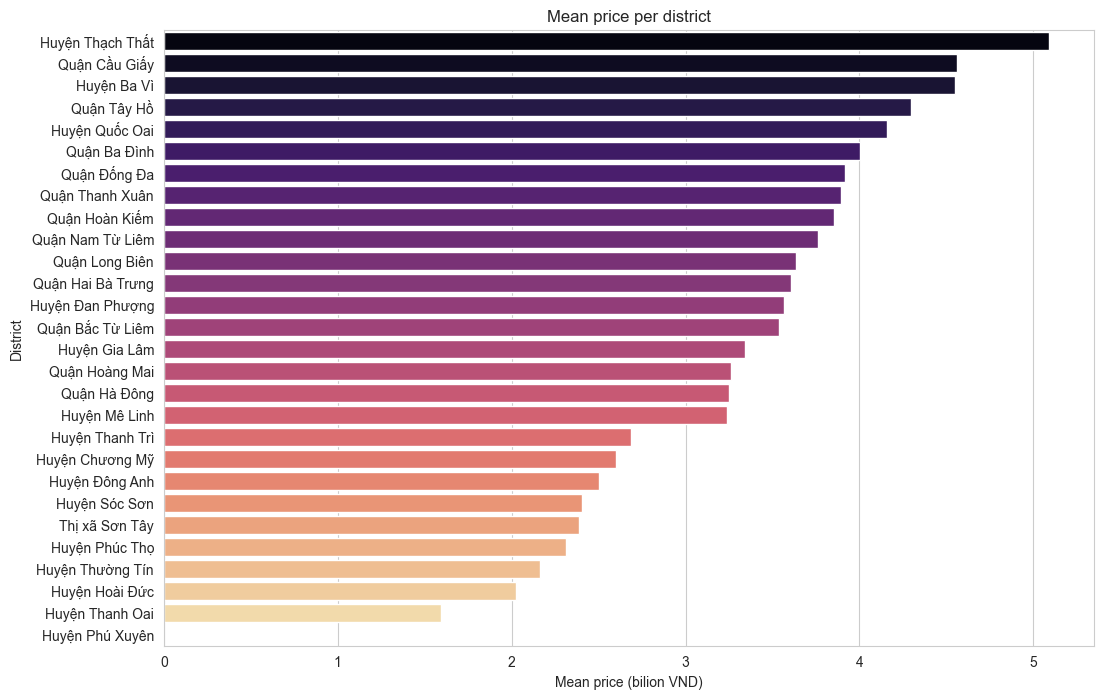

In [95]:
mean_price_per_district = df_train_no_outlier.groupby('District')['Price'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(
    x=mean_price_per_district.values, y=mean_price_per_district.index,
    order=mean_price_per_district.index, palette='magma'
)
plt.title('Mean price per district')
plt.xlabel('Mean price (bilion VND)')
plt.ylabel('District')
plt.show()

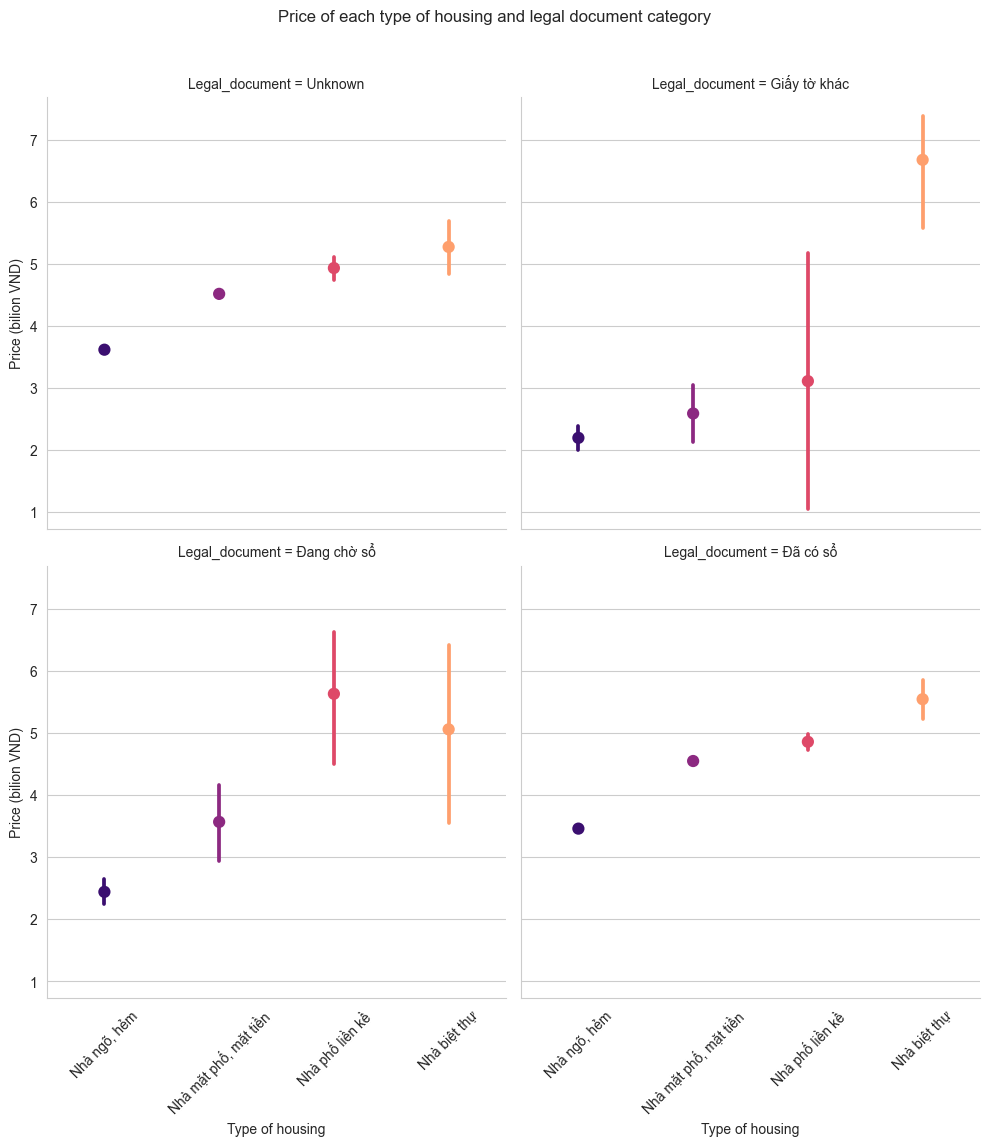

In [96]:
g = sns.catplot(data=df_train_no_outlier, x='Type_of_housing', y='Price', palette='magma', col='Legal_document', col_wrap=2, kind='point')
g.set_axis_labels('Type of housing', 'Price (bilion VND)')
g.fig.suptitle('Price of each type of housing and legal document category', y=1.05)
g.tick_params(axis='x', rotation=45)
plt.show()

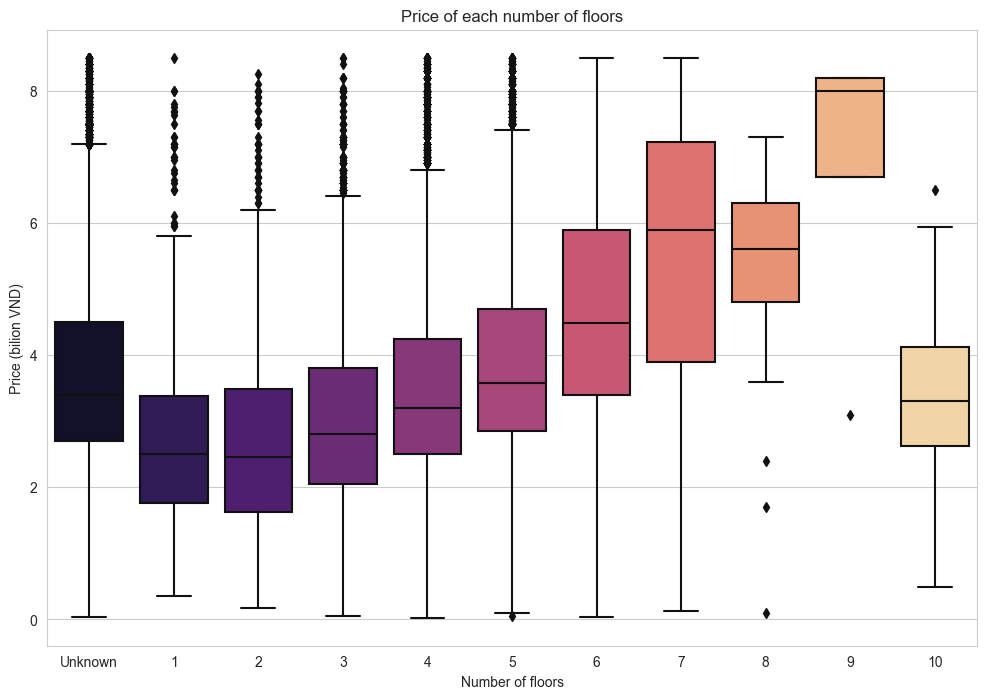

In [97]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train_no_outlier, x='Number_of_floors', y='Price', palette='magma')
plt.title('Price of each number of floors')
plt.xlabel('Number of floors')
plt.ylabel('Price (bilion VND)')
plt.show()

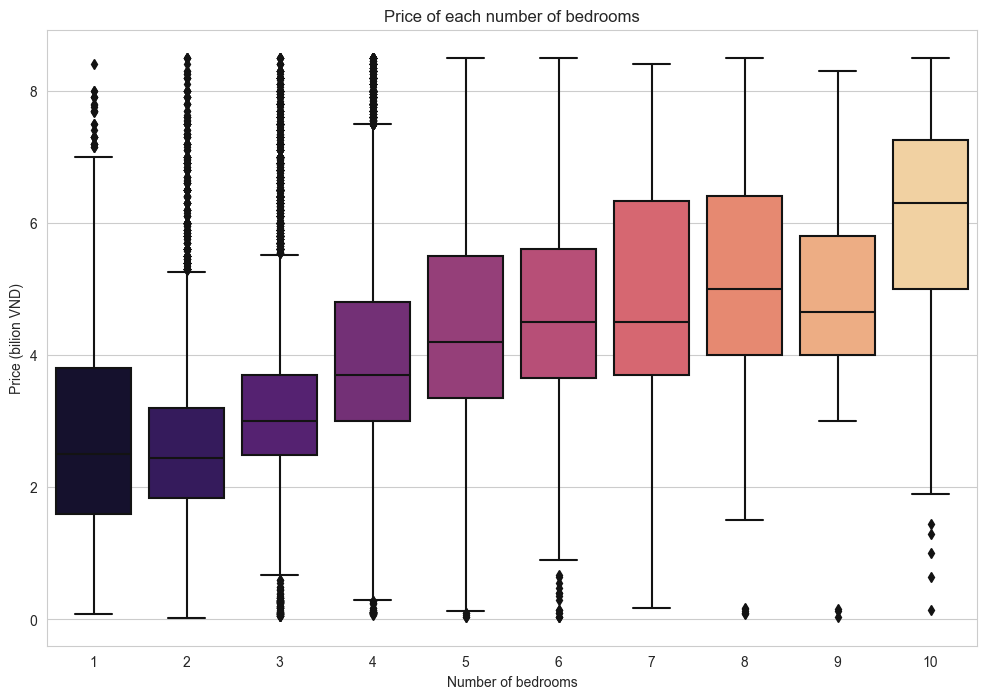

In [98]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train_no_outlier, x='Number_of_bedrooms', y='Price', palette='magma')
plt.title('Price of each number of bedrooms')
plt.xlabel('Number of bedrooms')
plt.ylabel('Price (bilion VND)')
plt.show()

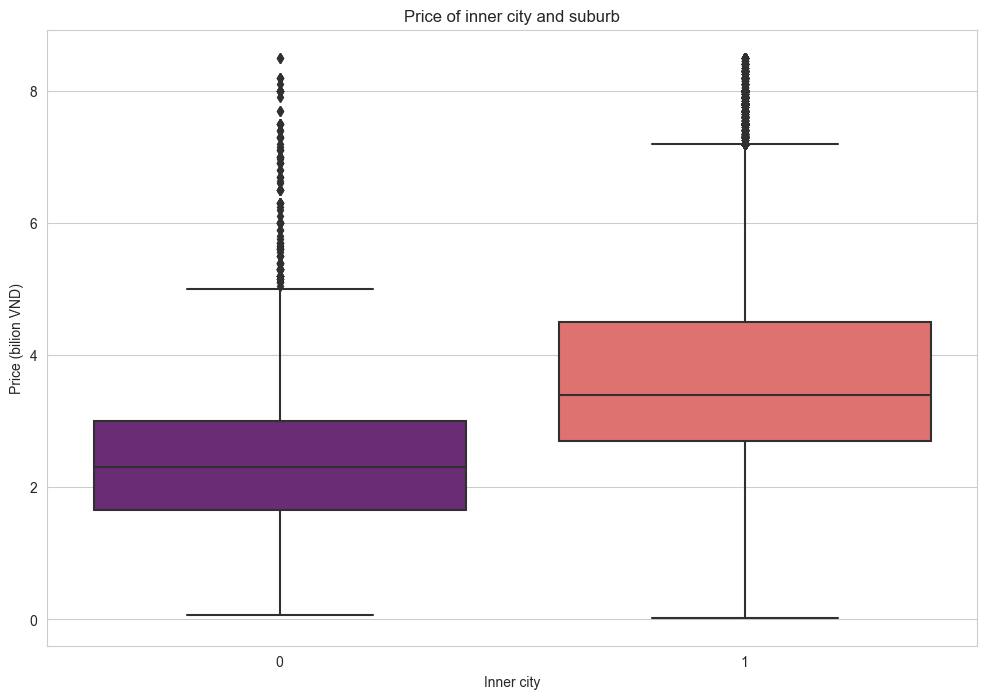

In [99]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train_no_outlier, x='Inner_city', y='Price', palette='magma')
plt.title('Price of inner city and suburb')
plt.xlabel('Inner city')
plt.ylabel('Price (bilion VND)')
plt.show()

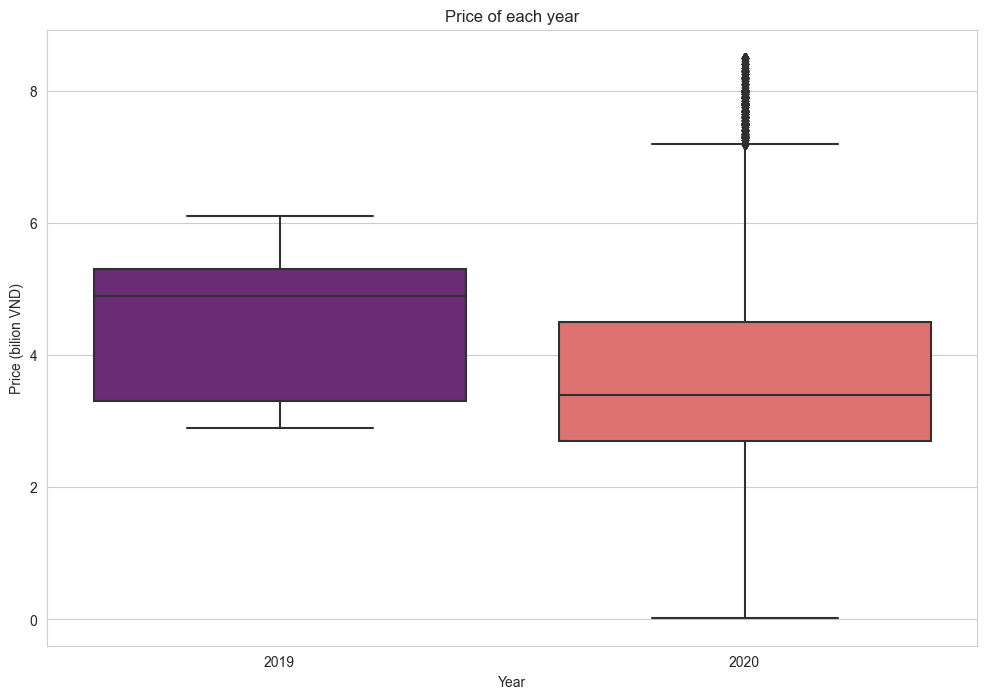

In [100]:
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_train_no_outlier, x='Year', y='Price', palette='magma')
plt.title('Price of each year')
plt.xlabel('Year')
plt.ylabel('Price (bilion VND)')
plt.show()

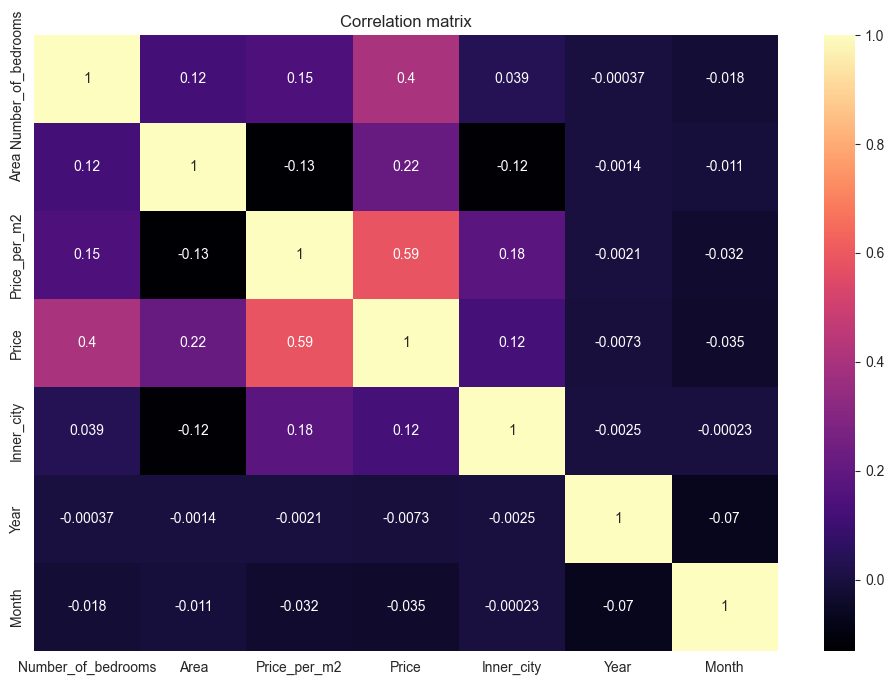

In [116]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_train_no_outlier.select_dtypes(include=['number']).corr(), cmap='magma', annot=True)
plt.title('Correlation matrix')
plt.show()

# Xây dựng mô hình dự đoán giá nhà

In [136]:
X = df_train_no_outlier.copy()
y = X.pop('Price')

In [137]:
X.drop(['Date', 'Price_per_m2', 'Unit', 'Year', 'Month'], axis=1, inplace=True)

## Baseline model

In [138]:
X.head()

District               Ward Type_of_housing Legal_document  \
0     Quận Hoàng Mai   Phường Tương Mai    Nhà ngõ, hẻm       Đã có sổ   
1       Quận Hà Đông   Phường Yên Nghĩa    Nhà ngõ, hẻm       Đã có sổ   
2       Quận Hà Đông    Phường Vạn Phúc    Nhà ngõ, hẻm       Đã có sổ   
3  Quận Hai Bà Trưng  Phường Thanh Nhàn    Nhà ngõ, hẻm       Đã có sổ   
5       Quận Đống Đa  Phường Trung Liệt    Nhà ngõ, hẻm       Đã có sổ   

  Number_of_floors  Number_of_bedrooms         Area  Inner_city  
0          Unknown                   2 27.000000000           1  
1          Unknown                   4 36.000000000           1  
2                3                   2 25.000000000           1  
3          Unknown                   4 38.000000000           1  
5                4                   4 40.000000000           1

In [139]:
X_baseline = X.select_dtypes(include=['number']).copy()

In [140]:
X_baseline.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59601 entries, 0 to 65880
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Number_of_bedrooms  59601 non-null  int32  
 1   Area                59601 non-null  float64
 2   Inner_city          59601 non-null  int64  
dtypes: float64(1), int32(1), int64(1)
memory usage: 3.6 MB


In [141]:
baseline_classifier = Classifier()
baseline_classifier.fit(X_baseline, y)

100%|██████████| 5/5 [00:12<00:00,  2.48s/it]


In [142]:
baseline_summary = baseline_classifier.summary()
baseline_summary.sort_values(by=['Score RMSE', 'Std RMSE', 'Score MAE', 'Std MAE'], ascending=True)

Score RMSE    Std RMSE   Score MAE     Std MAE
XGBoost       1.170453051 0.004821788 1.369983594 0.011310147
Random Forest 1.175691598 0.004093763 1.382267494 0.009643962
Decision Tree 1.186835958 0.003005849 1.408588627 0.007142190
KNN           1.258648950 0.007125662 1.584247953 0.017975179
Linear Model  1.352226798 0.009125451 1.828600588 0.024758854

## Encode categorical columns

### Ordinal encode

In [143]:
X_ordinal = X.copy()
for col in X.select_dtypes(include=['category']):
    X_ordinal[col] = X_ordinal[col].cat.codes

In [144]:
ordinal_encode_classifier = Classifier()
ordinal_encode_classifier.fit(X_ordinal, y)

100%|██████████| 5/5 [01:10<00:00, 14.09s/it]


In [145]:
ordinal_encode_summary = ordinal_encode_classifier.summary()
ordinal_encode_summary.sort_values(by=['Score RMSE', 'Std RMSE', 'Score MAE', 'Std MAE'], ascending=True)

Score RMSE    Std RMSE   Score MAE     Std MAE
XGBoost       0.995290663 0.006043268 0.990640026 0.012016104
Random Forest 1.044308628 0.007126051 1.090631291 0.014896763
KNN           1.093720354 0.009900168 1.196322225 0.021584416
Decision Tree 1.295991342 0.016780967 1.679875160 0.043584059
Linear Model  1.305201795 0.005191121 1.703578673 0.013560540

### Ordinal encoder + standard scale

In [146]:
scaler = StandardScaler()

In [147]:
X_scaled = pd.DataFrame(scaler.fit_transform(X_ordinal))
X_scaled.columns = X_ordinal.columns.astype(str)

In [148]:
scaled_classifier = Classifier()
scaled_classifier.fit(X_scaled, y)

100%|██████████| 5/5 [01:14<00:00, 14.87s/it]


In [149]:
scaled_summary = scaled_classifier.summary()
scaled_summary.sort_values(by=['Score RMSE', 'Std RMSE', 'Score MAE', 'Std MAE'], ascending=True)

Score RMSE    Std RMSE   Score MAE     Std MAE
XGBoost       0.995290663 0.006043268 0.990640026 0.012016104
Random Forest 1.044290611 0.006934076 1.090590961 0.014496976
KNN           1.105905520 0.004346702 1.223045912 0.009628786
Decision Tree 1.298102887 0.016022981 1.685327840 0.041646937
Linear Model  1.305201795 0.005191121 1.703578673 0.013560540

# Select XGBoost for final model

## Hyperparameter tuning

In [158]:
def objective(trial, X=X_scaled, y=y):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 1),
        'n_estimators': trial.suggest_int('n_estimators', 2, 8000),
        'max_depth': trial.suggest_int('max_depth', 0, 20),
        'min_split_loss': trial.suggest_float('min_split_loss', 0, 20),
        'subsample': trial.suggest_float('subsample', 0.1, 1),
    }

    kf = KFold(n_splits=5)
    scores = []
    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        model = XGBRegressor(**params, random_state=42, n_jobs=-1, tree_method='gpu_hist')
        model.fit(X_train, y_train, verbose=False)

        y_pred = model.predict(X_val)
        test_score = mean_squared_error(y_val, y_pred, squared=False)
        scores.append(test_score)
    
    return np.mean(scores)

In [159]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-07-15 00:48:25,186] A new study created in memory with name: no-name-14af0196-b0fc-486d-9581-ed9b6db9ea16
[I 2023-07-15 00:49:10,260] Trial 0 finished with value: 1.1250230572882367 and parameters: {'learning_rate': 0.9340149460286932, 'n_estimators': 4688, 'max_depth': 19, 'min_split_loss': 3.031056757066639, 'subsample': 0.7270562997299521}. Best is trial 0 with value: 1.1250230572882367.
[I 2023-07-15 00:49:55,908] Trial 1 finished with value: 1.0359117631637287 and parameters: {'learning_rate': 0.11283321785587012, 'n_estimators': 4637, 'max_depth': 6, 'min_split_loss': 15.002864008496006, 'subsample': 0.19642275580878366}. Best is trial 1 with value: 1.0359117631637287.
[I 2023-07-15 00:50:11,788] Trial 2 finished with value: 1.047764727745027 and parameters: {'learning_rate': 0.8852240216140673, 'n_estimators': 1713, 'max_depth': 11, 'min_split_loss': 11.697121458750612, 'subsample': 0.7412674904024358}. Best is trial 1 with value: 1.0359117631637287.
[I 2023-07-15 00:52:

Number of finished trials: 200
Best trial: {'learning_rate': 0.021198546238726898, 'n_estimators': 1631, 'max_depth': 7, 'min_split_loss': 0.001675880790564889, 'subsample': 0.8996878314239521}


In [160]:
params = {'learning_rate': 0.021198546238726898, 'n_estimators': 1631, 'max_depth': 7, 'min_split_loss': 0.001675880790564889, 'subsample': 0.8996878314239521}

In [161]:
model = XGBRegressor(**params, random_state=42, n_jobs=-1, tree_method='gpu_hist')
model.fit(X_scaled, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.021198546238726898,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, min_split_loss=0.001675880790564889,
             missing=nan, monotone_constraints=None, n_estimators=1631,
             n_jobs=-1, num_parallel_tree=None, predictor=None, ...)

## Processing test-set

In [163]:
X_test = df_test.copy()
y_test = X_test.pop('Price')

In [165]:
X_test.drop(['Date', 'Price_per_m2', 'Unit', 'Year', 'Month'], axis=1, inplace=True)

In [166]:
X_ordinal_test = X_test.copy()
for col in X_test.select_dtypes(include=['category']):
    X_ordinal_test[col] = X_ordinal_test[col].cat.codes

In [167]:
X_scaled_test = pd.DataFrame(scaler.transform(X_ordinal_test))
X_scaled_test.columns = X_ordinal_test.columns.astype(str)

## Testing

In [168]:
y_pred = model.predict(X_scaled_test)
print('RMSE score:', mean_squared_error(y_test, y_pred, squared=False))
print('MAE score:', mean_absolute_error(y_test, y_pred))

RMSE score: 78.57697097217158
MAE score: 3.2443219022505043


# Summary

In [169]:
df_pred = pd.DataFrame({
    'y_pred': y_pred,
    'y_test': y_test,
    'error': abs(y_pred - y_test)
})

In [170]:
df_pred.head()

y_pred       y_test        error
0 4.298893452  4.000000000  0.298893452
1 5.150403023 32.799900000 27.649496977
2 2.843826056  2.600150000  0.243676056
3 4.944609165  5.499900000  0.555290835
4 5.546931744  5.200000000  0.346931744

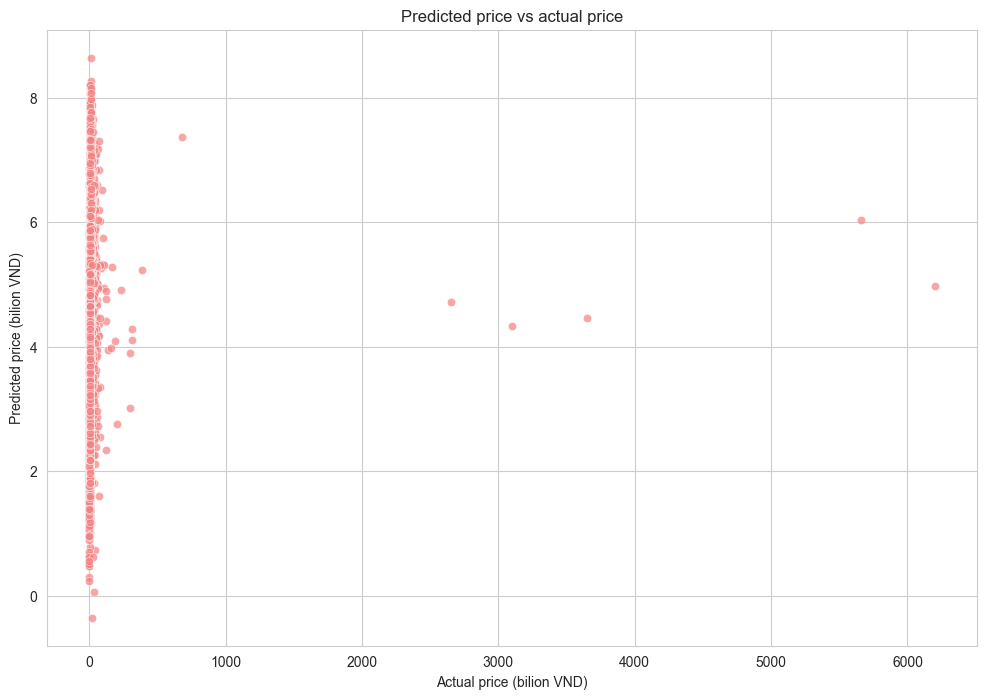

In [172]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pred, x='y_test', y='y_pred', alpha=0.7, color='#F38181')
plt.title('Predicted price vs actual price')
plt.xlabel('Actual price (bilion VND)')
plt.ylabel('Predicted price (bilion VND)')
plt.show()

In [174]:
# Top 10 houses with highest error

df_pred.sort_values(by='error', ascending=False).head(10)

y_pred         y_test          error
9823  4.979243279 6200.000000000 6195.020756721
12576 6.040565968 5656.555556000 5650.514990032
4989  4.467294216 3649.998860000 3645.531565784
614   4.337861538 3099.999969000 3095.662107462
8140  4.715719223 2649.998520000 2645.282800777
10166 7.372033596  679.999999980  672.627966384
10475 5.228681087  390.000000000  384.771318913
314   4.114246845  310.000500000  305.886253155
11427 4.289424896  309.997800000  305.708375104
6979  3.896793365  299.999999988  296.103206623

In [176]:
# Only see prediction which not outlier

iqr = df_pred['y_test'].quantile(0.75) - df_pred['y_test'].quantile(0.25)
upper_bound = df_pred['y_test'].quantile(0.75) + 1.5 * iqr
lower_bound = df_pred['y_test'].quantile(0.25) - 1.5 * iqr

df_pred_no_outlier = df_pred[(df_pred['y_test'] < upper_bound) & (df_pred['y_test'] > lower_bound)]

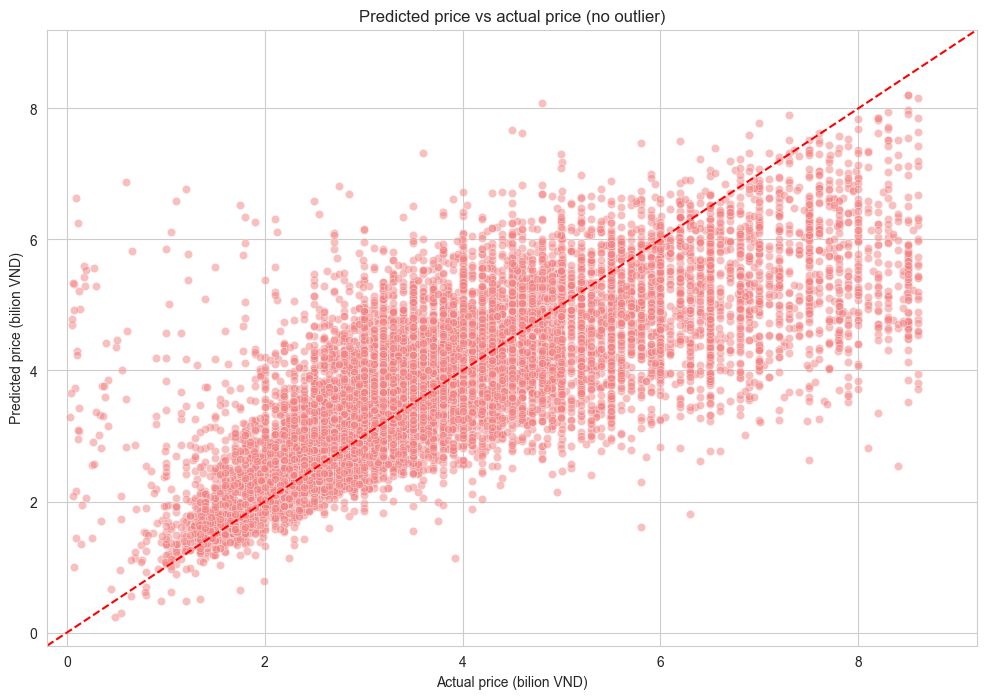

In [177]:
lim = (-0.2, 9.2)

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pred_no_outlier, x='y_test', y='y_pred', alpha=0.5, color='#F38181')
plt.xlim(*lim)
plt.ylim(*lim)
plt.plot(lim, lim, color='red', linestyle='--')
plt.title('Predicted price vs actual price (no outlier)')
plt.xlabel('Actual price (bilion VND)')
plt.ylabel('Predicted price (bilion VND)')
plt.show()

In [178]:
def plot_pred_actual(col, col_wrap=4):
    lim = (-0.2, 9.2)
    g = sns.relplot(data=df_pred_no_outlier, x='y_test', y='y_pred', alpha=0.7, color='#F38181', col=X_test[col], kind='scatter', col_wrap=col_wrap)
    for ax in g.axes.flat:
        ax.set_xlim(*lim)
        ax.set_ylim(*lim)
        ax.plot(lim, lim, color='red', linestyle='--')
    g.fig.suptitle('Predicted price vs actual price (no outlier)', y=1.05)
    g.set_axis_labels('Actual price (bilion VND)', 'Predicted price (bilion VND)')
    plt.show()

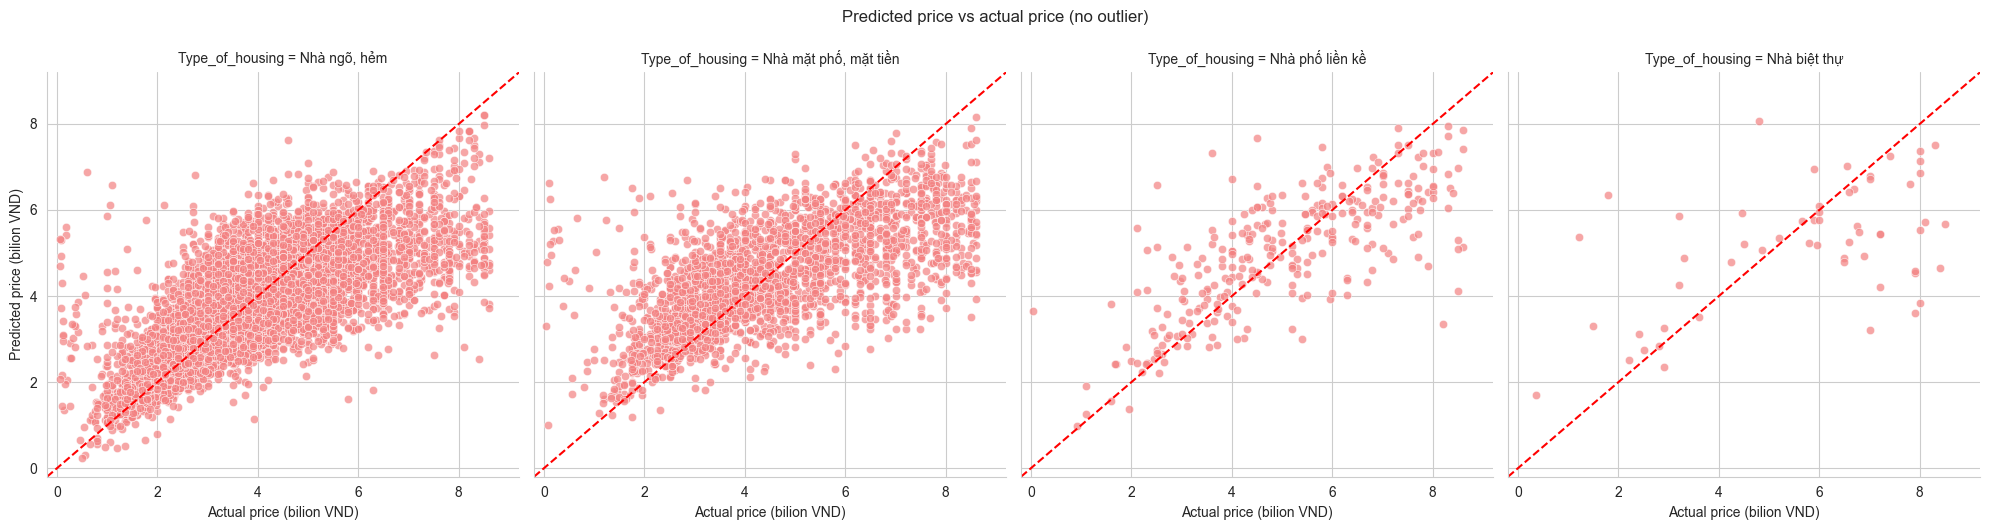

In [180]:
plot_pred_actual('Type_of_housing')

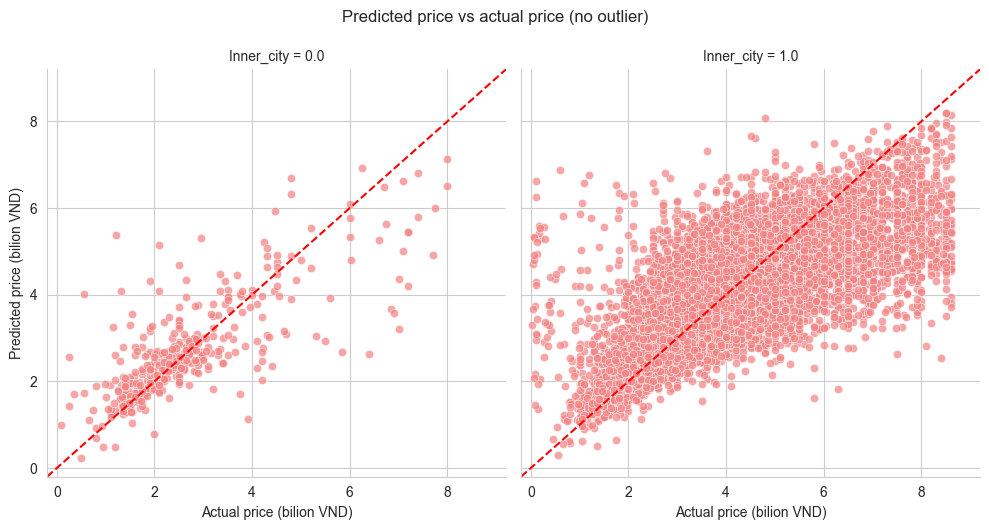

In [181]:
plot_pred_actual('Inner_city', col_wrap=2)

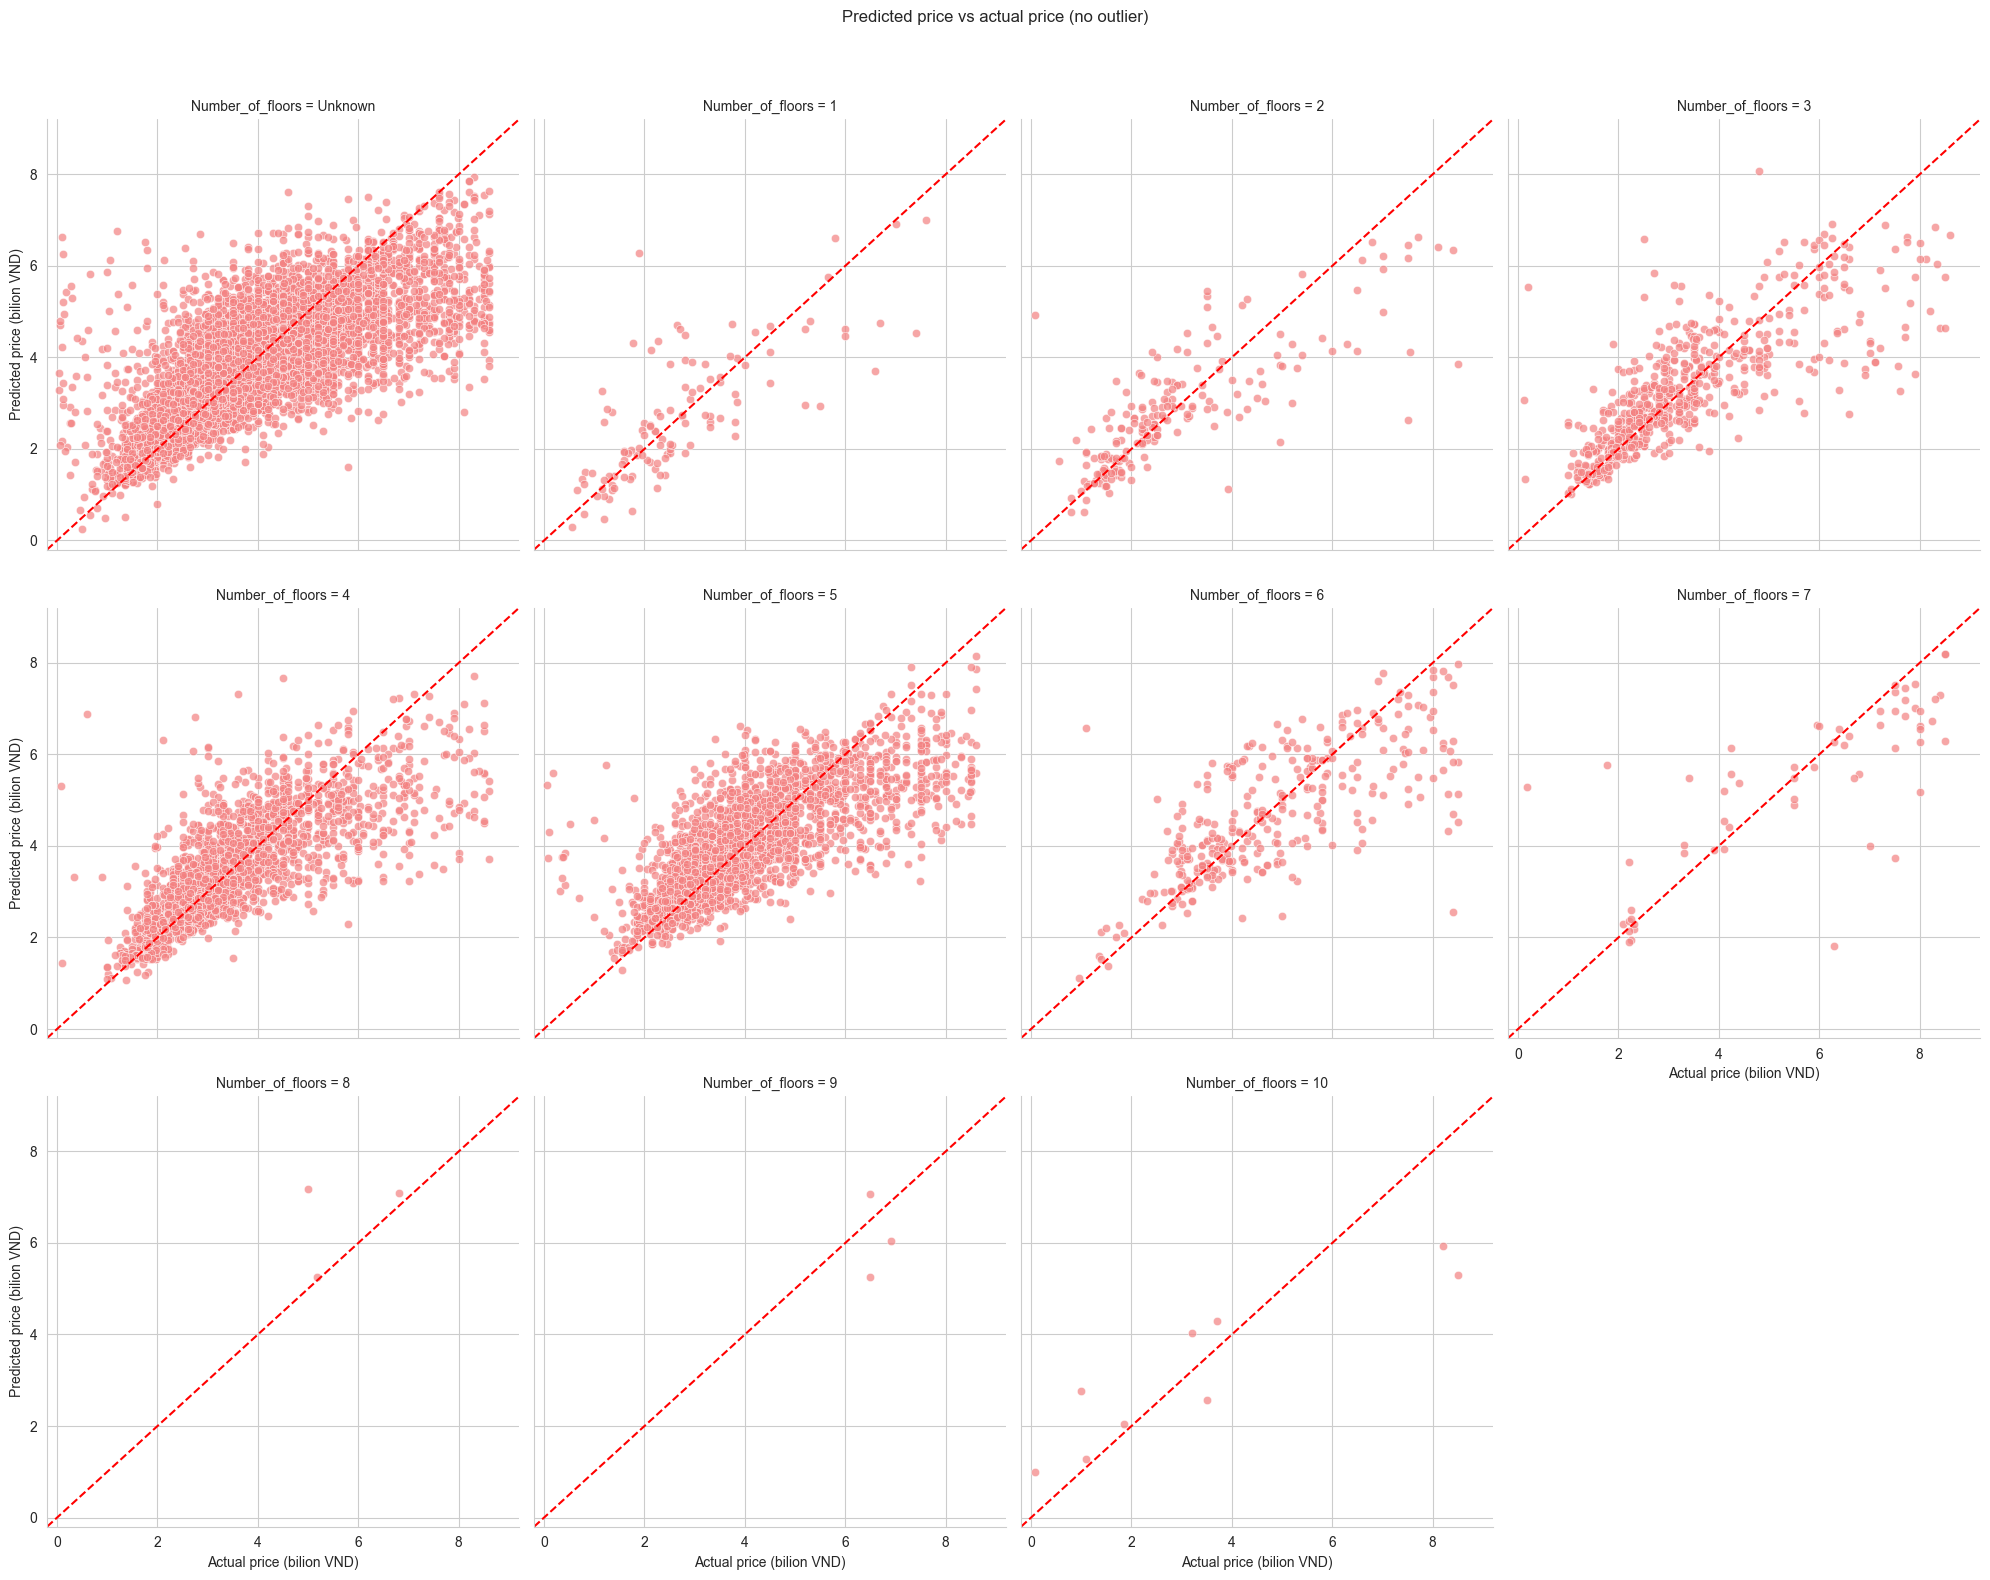

In [182]:
plot_pred_actual('Number_of_floors')

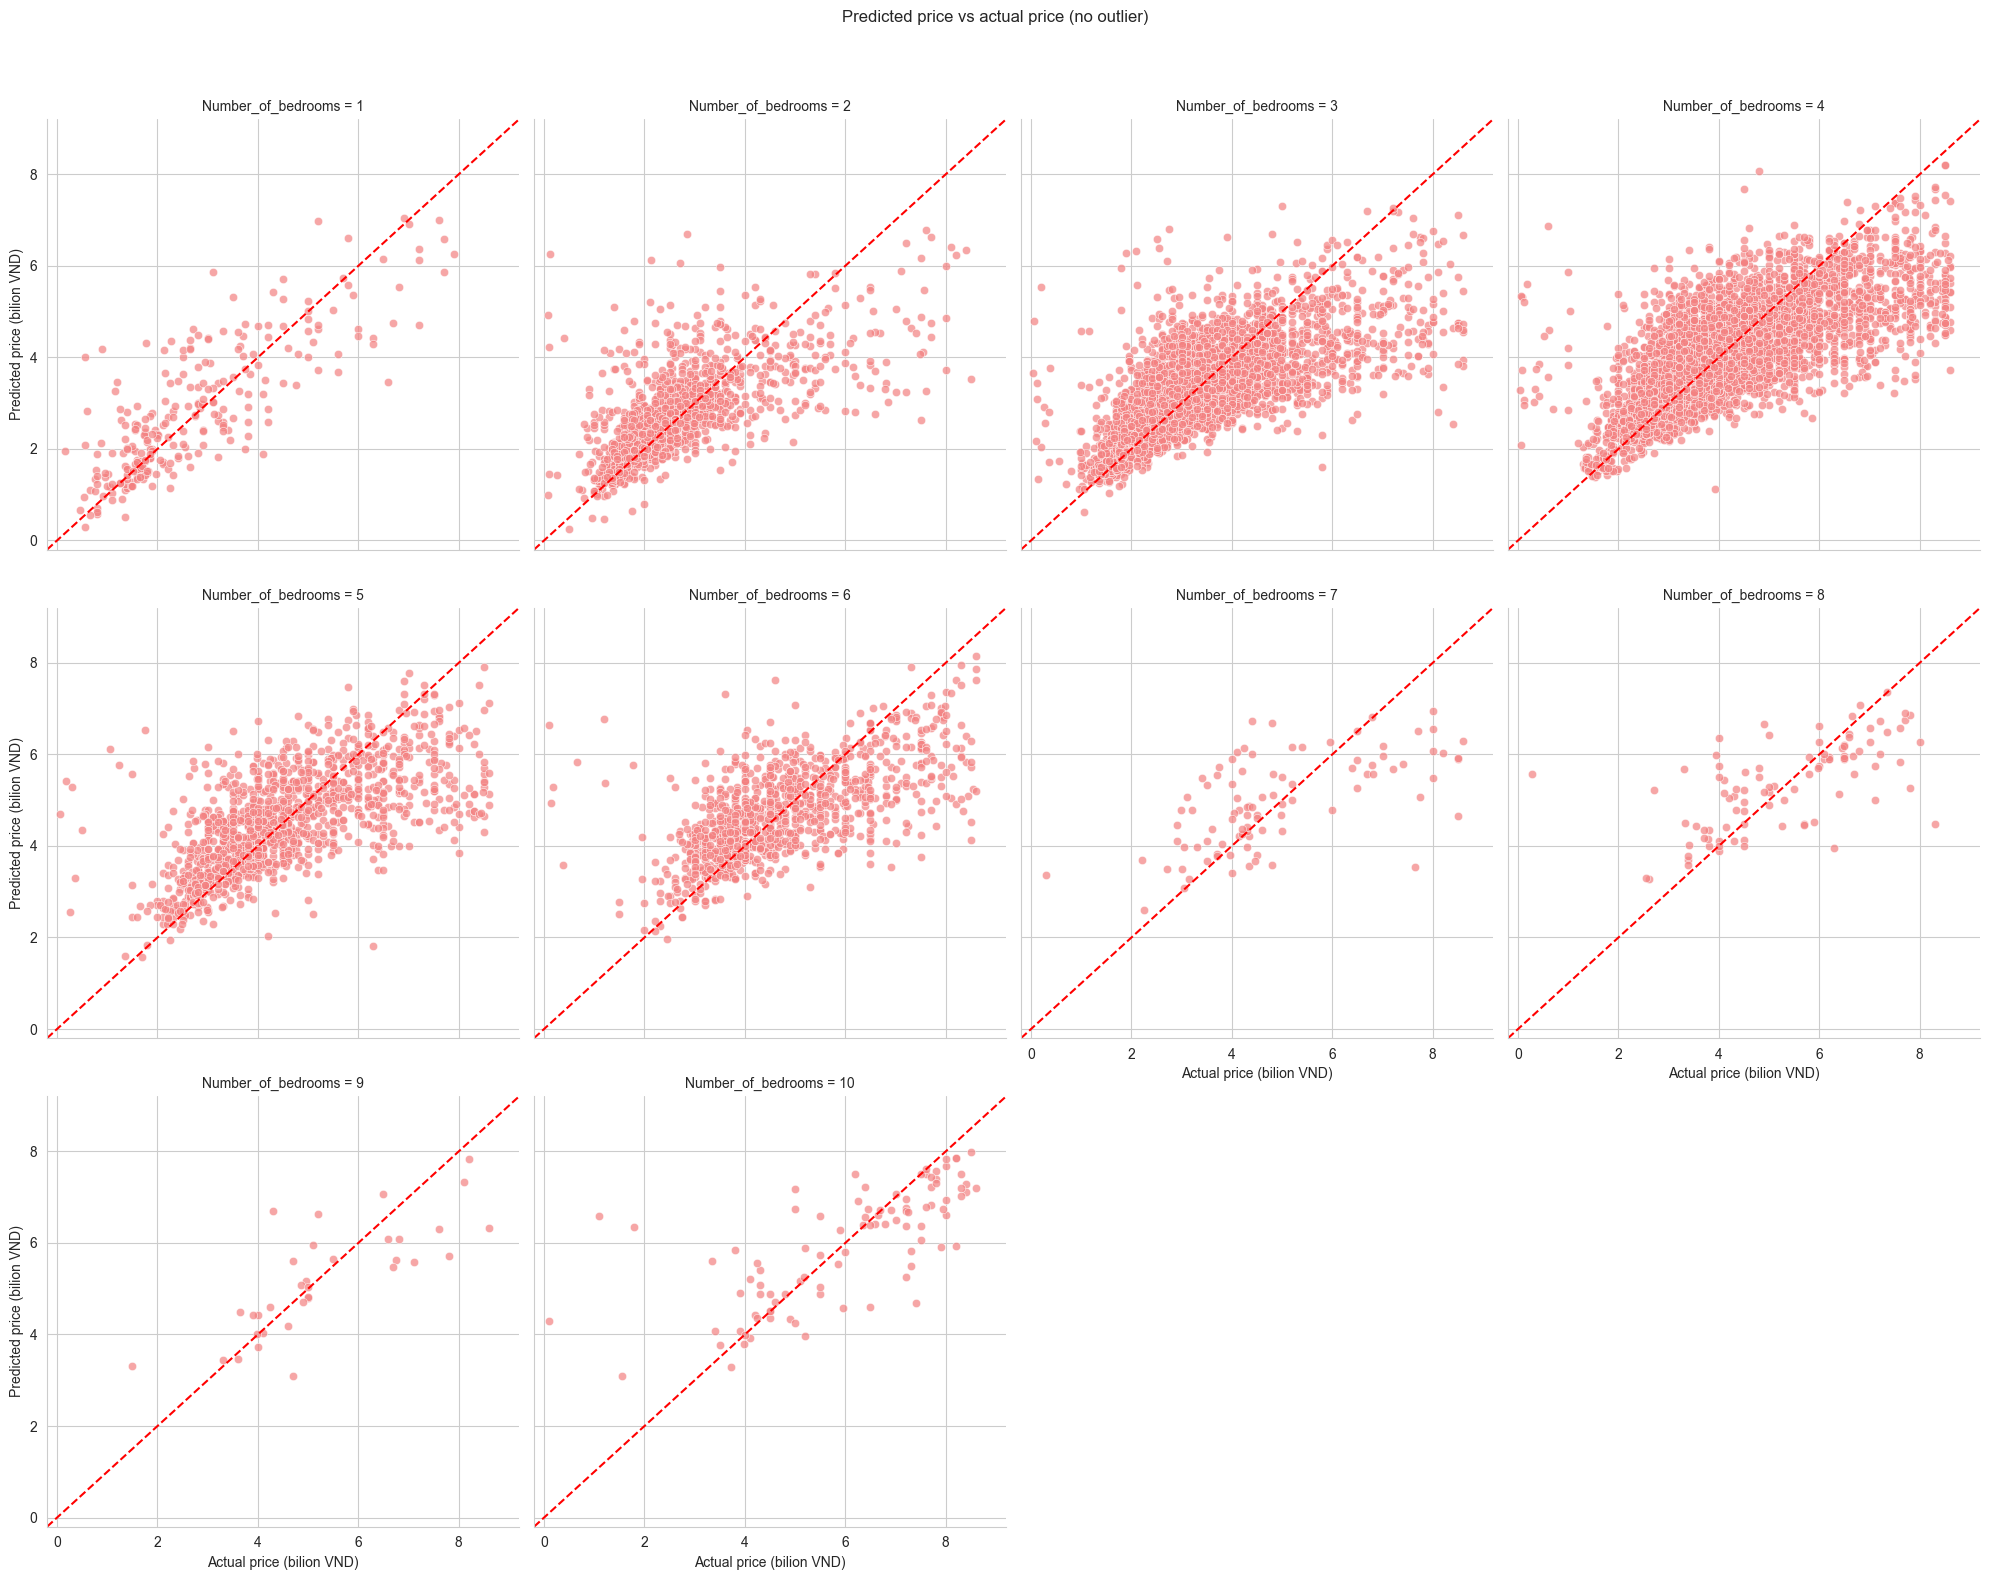

In [183]:
plot_pred_actual('Number_of_bedrooms')

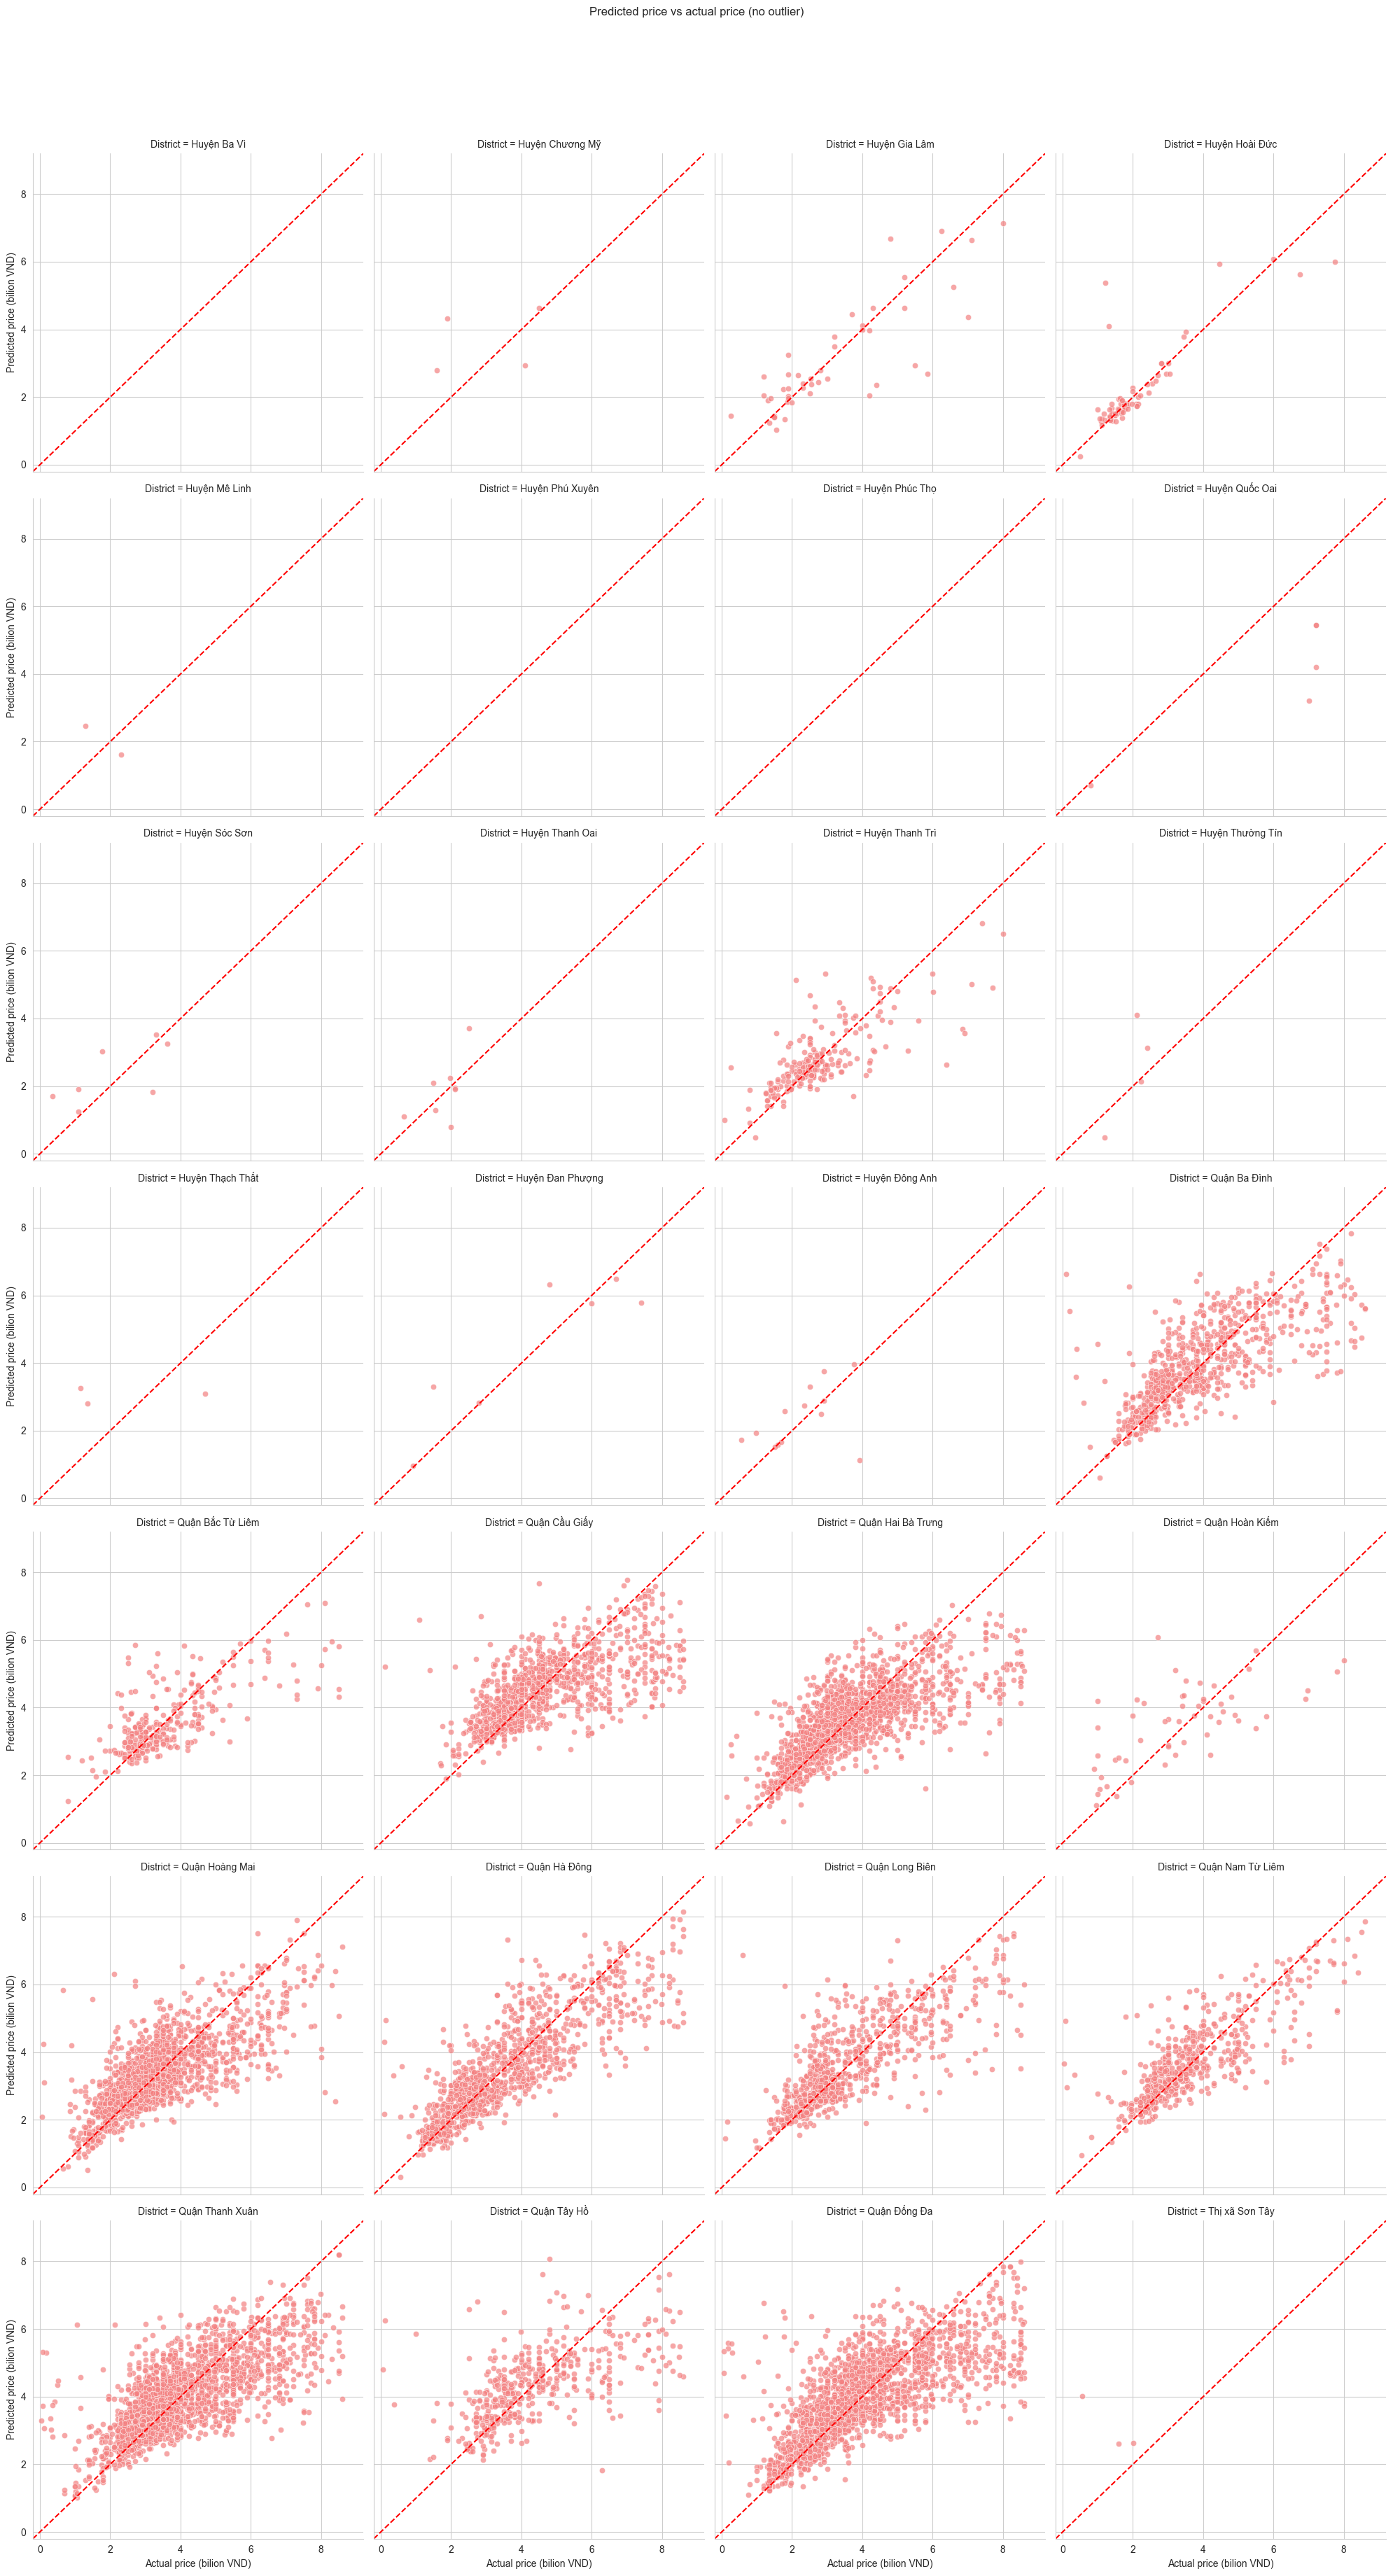

In [186]:
plot_pred_actual('District')